# Investigate temperature change potential of different aerosol forcing time series


## TODO in revision
- ~~Nitrate aerosol: competition with sulfate. May not be a great deal of models but at least we can do Oslo-CTM3~~
- Percentile matching ERFari and ERFaci: at least report weighted mean as headline values as sum of weighted percentiles != weighted percentiles of sum (but this does seem to hold for weighted means).
- correlations between ERFari and ERFaci in CMIP6 models
- carbon brief want my take on it - let them know when accepted
- make this into a self-contained GitHub repo
- run RFMIP all forcing expts in two layer model
- fix BC on snow uncertainty

This is a bit circular as we need the non-aerosol forcing first. Could come after the AR6

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import urllib
import json
import wquantiles
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from scipy.optimize import root
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from fair.forcing.ghg import etminan
from fair.constants import molwt
import tqdm.autonotebook as tqdman
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
import random

from ar6.utils.h5 import *
from ar6.utils.statistics import rmse, weighted_percentile
from ar6.utils.ensemble import knutti_score
from ar6.utils import check_and_download

from openscm_units import unit_registry as ur
from scmdata import ScmRun, run_append

import openscm_twolayermodel
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel
from openscm_twolayermodel.base import Model

import h5py

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

## Earth system heat uptake from Matt Palmer

Use OHU/0.9 for total earth uptake
this replaces von Schuckmann

In [3]:
df = pd.read_csv('../data_input/AR6_OHC_ensemble_FGDprelim.csv', skiprows=1)
#df['Central Estimate Full-depth']
#df['Full-depth Uncertainty (1-sigma)']
#df['Year']

In [4]:
# Should I de-apply rapid adjustments to historical estimates? Climate models from 1850-2014 agree with Etminan with no adjustment
# no: we should keep the adjustments in
# make this precisely the SOD assessment

ssp245_allforcing = pd.read_csv('/nfs/see-fs-02_users/mencsm/ssp_erf/SSPs/ERF_ssp245_1750-2500.csv')  # to do change to FGD: need the non-aerosol forcing first!
baseline_forcing = ssp245_allforcing.copy()

baseline_forcing.drop(
    labels=['total_anthropogenic','total'],
    axis='columns',
    inplace=True
)
baseline_forcing['total_anthropogenic'] = baseline_forcing[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-radiation_interactions','aerosol-cloud_interactions']].sum(axis=1)
baseline_forcing['total'] = baseline_forcing['total_anthropogenic'] + baseline_forcing['total_natural']
pd.set_option('display.max_rows', 999)
baseline_forcing

,year,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_natural,total_anthropogenic,total
0,1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.206179,0.073621,0.279801,0.000000,0.279801
1,1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000049,0.000000e+00,0.002151,0.005939,-0.000288,-0.000229,0.206192,0.055275,0.261467,0.010122,0.271589
2,1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000097,0.000000e+00,0.003576,0.009301,-0.000388,-0.000458,0.206196,0.025197,0.231393,0.017129,0.248522
3,1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000146,0.000000e+00,0.002184,0.006061,-0.000299,-0.000687,0.206197,-0.010981,0.195217,0.014905,0.210121
4,1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000194,0.000000e+00,-0.001185,-0.002432,0.000018,-0.000916,0.206198,-0.045395,0.160802,0.005679,0.166481
5,1755,0.007852,0.002713,0.000432,3.979005e-09,0.001500,0.000000,0.000242,0.000000e+00,0.000973,0.001731,0.000016,-0.001145,0.179229,-0.069873,0.109356,0.014315,0.123671
6,1756,0.009421,0.003255,0.000519,4.774806e-09,0.001800,0.000000,0.000291,0.000000e+00,0.001943,0.005781,-0.000334,-0.001374,-0.071471,-0.077455,-0.148926,0.021300,-0.127626
7,1757,0.010989,0.003796,0.000605,5.570607e-09,0.002100,0.000000,0.000339,0.000000e+00,-0.001554,-0.006684,0.000581,-0.001604,0.072553,-0.058313,0.014240,0.008569,0.022808
8,1758,0.012557,0.004337,0.000691,6.366408e-09,0.002400,0.000000,0.000388,0.000000e+00,-0.000203,-0.002135,0.000265,-0.001833,0.159469,-0.006956,0.152514,0.016468,0.168981
9,1759,0.014125,0.004878,0.000778,7.162209e-09,0.002700,0.000000,0.000436,0.000000e+00,-0.000901,-0.003191,0.000226,-0.002062,0.190418,0.043543,0.233961,0.016989,0.250950


In [5]:
# Model-specific ERF datasets
CanESM5_aerforcing = pd.read_csv('../data_input/CanESM5.csv')
E3SM_aerforcing = pd.read_csv('../data_input/E3SM.csv')
GISS_aerforcing = pd.read_csv('../data_input/GISS-E2-1-G.csv')
HadGEM3_aerforcing = pd.read_csv('../data_input/HadGEM3-GC31-LL.csv')
MIROC6_aerforcing = pd.read_csv('../data_input/MIROC6.csv')
GFDL_aerforcing = pd.read_csv('../data_input/GFDL-CM4.csv')
GFDLESM_aerforcing = pd.read_csv('../data_input/GFDL-ESM4.csv')
NorESM2_aerforcing = pd.read_csv('../data_input/NorESM2-LM.csv')
UKESM_aerforcing = pd.read_csv('../data_input/UKESM1-0-LL.csv')
IPSL_aerforcing = pd.read_csv('../data_input/IPSL-CM6A-LR.csv')
MRI_aerforcing = pd.read_csv('../data_input/IPSL-CM6A-LR.csv')

# Lund et al., 2019, ACP: (details in supplement)
# https://www.atmos-chem-phys.net/19/13827/2019/acp-19-13827-2019-supplement.pdf
# we use SSP2-4.5 for extension
Lund_rfacipoints = [0, -0.03, -0.08, -0.12, -0.13, -0.15, -0.17, -0.21, -0.26, -0.33, -0.38, -0.37,
                    -0.40, -0.44, -0.40, -0.45, -0.44, -0.44, -0.42, -0.36, -0.35, -0.26, -0.11]
Lund_rfaripoints = [0, 0.002, -0.03, -0.05, -0.06, -0.06, -0.08, -0.10, -0.14, -0.24, -0.26, -0.24,
                    -0.24, -0.22, -0.19, -0.20, -0.17, -0.17, -0.13, -0.10, -0.13, -0.09, -0.09]
Lund_timepoints  = [1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1985, 1990, 1995,
                    2000, 2005, 2010, 2014, 2015, 2020, 2030, 2050, 2100]
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints)+np.array(Lund_rfaripoints))
Lund_aerforcing = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfaripoints))
Lund_ERFari = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints))
Lund_ERFaci = f(np.arange(1750,2101))

Using assessed GMST / GSAT

In [6]:
# check_and_download(
#     '../data_input/had4_krig_annual_v2_0_0.txt',
#     'https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt'
# )

# cw_temp = np.loadtxt('../data_input/had4_krig_annual_v2_0_0.txt')
# cw_temp
xl = pd.read_excel('../data_input/Consolidated GMST time series.xlsx', skiprows=8, skipfooter=9)
Tobs=xl['5-set mean'][:-1].values
years=xl['Unnamed: 0'][:-1].values

-1.5782582212808597e-17
1.014904397254902


169

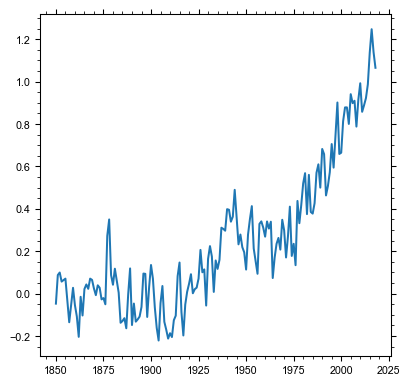

In [7]:
pl.plot(years, Tobs)
print(np.mean(Tobs[:51]))
print(np.mean(Tobs[159:169]))
len(Tobs)

## Simple experiment with ECS=3.7 and default Geoffroy params

In [8]:
models = ['CanESM5','E3SM','GFDL-ESM4','GFDL-CM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','NorESM2-LM','UKESM1-0-LL']

# from somewhere import model_colors

colors = {
    'CMIP6-constrained' : '0.3',
    'CEDS-new'       : '0.6',
    'CanESM5'        : 'red',#'#1e4c24',
    'E3SM'           : 'darkorange',
    'GFDL-ESM4'      : 'yellow', 
    'GFDL-CM4'       : 'yellowgreen',#'green',
    'GISS-E2-1-G'    : 'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR'   : 'teal',
    'MIROC6'         : 'blue',#b85fb7',
    'MRI-ESM2-0'     : 'blueviolet',
    'NorESM2-LM'     : 'purple',#'red',
    'UKESM1-0-LL'    : 'crimson',
    'observations'   : 'black',
    'Oslo-CTM3'      : 'pink',
}

ls = {
    'CMIP6-constrained'  : '-',
    'CEDS-new' : '-',
    'CanESM5'        : '-',
    'E3SM'           : '-',
    'GFDL-ESM4'      : '-',
    'GFDL-CM4'       : '-',
    'GISS-E2-1-G'    : '-',
    'HadGEM3-GC31-LL': '-',
    'IPSL-CM6A-LR'   : '-',
    'MIROC6'         : '-',
    'MRI-ESM2-0'     : '-',
    'NorESM2-LM'     : '-',
    'UKESM1-0-LL'    : '-',
    'Oslo-CTM3'      : '-',
    'observations'   : '-',
}

In [9]:
Lund_forcing = ssp245_allforcing.drop(
    labels=['aerosol-radiation_interactions','aerosol-cloud_interactions','total_anthropogenic','total'],
    axis='columns'
)
Lund_forcing['aerosol'] = np.zeros(len(Lund_forcing))
Lund_forcing.loc[0:349, 'aerosol'] = Lund_aerforcing[0:350]
Lund_forcing.loc[265:, 'aerosol'] = Lund_aerforcing[264]#RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='GFDL-CM4')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERF'].values[0]
#Lund_forcing.loc[350:, 'aerosol'] = Lund_aerforcing[350]
Lund_forcing['total_anthropogenic'] = Lund_forcing[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol']].sum(axis=1)
Lund_forcing['total'] = Lund_forcing['total_anthropogenic'] + Lund_forcing['total_natural']
#pl.plot(np.arange(1750,2101), Lund_forcing.loc[:350,'aerosol'])

In [10]:
with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
cmip6_models['dl']['mean']

802.7537729867868

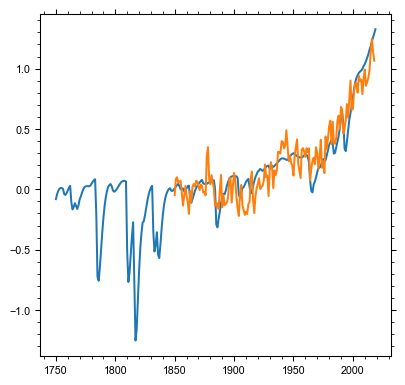

In [11]:
runner = TwoLayerModel()
runner.dl = cmip6_models['dl']['mean'] * ur(cmip6_models['dl']['units'])
runner.du = cmip6_models['du']['mean']  * ur(cmip6_models['du']['units'])
runner.eta = cmip6_models['eta']['mean'] * ur(cmip6_models['eta']['units'])
runner.lambda0 = cmip6_models['lambda0']['mean'] *  ur(cmip6_models['lambda0']['units'])
runner.efficacy = cmip6_models['efficacy']['mean'] * ur(cmip6_models['efficacy']['units'])

driver = ScmRun(
    data=baseline_forcing['total'][:270],
    index=np.arange(1750,2020),
    columns={
        "unit": "W/m^2",
        "model": "idealised",
        "scenario": "ssp245",
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
output = runner.run_scenarios(driver)
pl.plot(np.arange(1750,2020), output.filter(variable='Surface Temperature|Upper').relative_to_ref_period_mean(year=range(1850,1901)).timeseries().values.squeeze())
pl.plot(np.arange(1850,2019), Tobs)

In [12]:
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
# construct correlation matrix
#pd.set_option('precision', 4)
params.corr()

,dl,du,eta,efficacy,lambda0,F4xCO2
dl,1.000000,0.617931,0.138834,-0.364489,0.416454,0.062794
du,0.617931,1.000000,-0.358705,-0.860692,0.335435,-0.180006
eta,0.138834,-0.358705,1.000000,0.335756,0.134440,0.284346
efficacy,-0.364489,-0.860692,0.335756,1.000000,-0.232162,0.325604
lambda0,0.416454,0.335435,0.134440,-0.232162,1.000000,0.476300
F4xCO2,0.062794,-0.180006,0.284346,0.325604,0.476300,1.000000


In [13]:
samples = 100000 # need list of variables and seeds
# need also to tune two layer model better

kde = st.gaussian_kde(params.T)
geoff_sample = kde.resample(size=int(samples*1.3), seed=3170812)
# remove unphysical combinations
geoff_sample[:,geoff_sample[0,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[4,:] <= 0.5] = np.nan
geoff_sample[:,geoff_sample[2,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[3,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[5,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[1,:] <= 30] = np.nan
#geoff_sample = geoff_sample[~np.isnan(geoff_sample)]
mask = np.all(np.isnan(geoff_sample), axis=0)
geoff_sample = geoff_sample[:,~mask]
geoff_sample_df=pd.DataFrame(
    data=geoff_sample[:,:samples].T, columns=['dl', 'du', 'eta', 'efficacy', 'lambda0', 'F4xCO2']
)
#geoff_sample_df.to_csv('../data/geoff_sample.csv', index=False)
geoff_sample_df

,dl,du,eta,efficacy,lambda0,F4xCO2
0,947.576917,41.092349,0.602535,1.653388,1.252392,7.860257
1,902.560481,66.032113,0.575039,1.288612,1.115789,8.022128
2,720.697946,41.987100,0.815988,1.460146,0.978028,8.474900
3,921.099568,54.369959,0.767356,1.298473,1.725520,8.321813
4,820.047362,36.480343,0.659119,1.641808,0.758266,8.143469
...,...,...,...,...,...,...
99995,397.328641,60.636920,0.484961,1.181593,2.044191,6.869303
99996,2569.763665,106.982032,0.583210,0.548771,1.335587,6.937946
99997,77.228598,40.101298,0.535843,1.365367,2.110963,10.409830
99998,525.627891,44.289533,0.626563,1.205533,0.721211,6.696775


In [14]:
# fractional uncertainties - based on the FAIR code

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.15,      # other WMGHGs
    0.50,      # tropospheric O3
    0.50,      # stratospheric O3
    1.00,      # stratospheric WV from CH4
    0.67,      # contrails approx - could half range it (0.019 - 0.0574 - 0.098)
    0.00,      # bc on snow - lognormal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    1,         # solar: TO DO NEED TO UPDATE
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,12), loc=np.ones((samples,12)), scale=np.ones((samples, 12)) * unc_ranges[None,:], random_state=seed)
scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## stratospheric ozone is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
#scale_normals[scale_normals[:,5]<1,5] = 0.5*(scale_normals[scale_normals[:,5]<1,5]-1) + 1

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)


In [15]:
np.percentile(scale_df['bc_on_snow']*0.08, (5,50,95))

array([0.03524134, 0.07999342, 0.18187143])

In [17]:
ERFari = load_dict_from_hdf5('../data_input_large/ERFari.h5')
ERFaci = load_dict_from_hdf5('../data_input_large/ERFaci.h5')

/nfs/b0110/Users/mencsm/ar6/src/ar6/utils/h5.py:43: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [18]:
# Define our dicts
temp = {}
ks = {}
ohc = {}
hflux = {}
#ks_ocean = {}
ks['temp'] = {}
ks['ohc'] = {}
ks['multi'] = {}

In [19]:
intvar = np.loadtxt('/nfs/a65/pmcjs/AR6_tuning/aerosols/internal_variability_piControl.txt')

## Run climate model

In [ ]:
runner = TwoLayerModel()
output = []

dl = np.array(geoff_sample_df['dl']) * ur(cmip6_models['dl']['units'])
du = np.array(geoff_sample_df['du'])  * ur(cmip6_models['du']['units'])
eta = np.array(geoff_sample_df['eta']) * ur(cmip6_models['eta']['units'])
lambda0 = np.array(geoff_sample_df['lambda0']) *  ur(cmip6_models['lambda0']['units'])
efficacy = np.array(geoff_sample_df['efficacy']) * ur(cmip6_models['efficacy']['units'])

for i in tqdman.tqdm(range(500), desc="Parameter settings"):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['CEDS-UPDATE'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CEDS-UPDATE'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    driver = ScmRun(
        data=in_forcing['total'][:270],#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "idealised",
            "scenario": "ssp245",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": i
        }
    )
    runner.dl = dl[i]
    runner.du = du[i]
    runner.eta = eta[i]
    runner.lambda0 = lambda0[i]
    runner.efficacy = efficacy[i]
    runner.timestep = 1 * ur("month")
    output.append(runner.run_scenarios(driver, progress=False))
output = run_append(output)

In [33]:
temp['CEDS-UPDATE']
output.filter(variable='Surface Temperature|Upper').timeseries().values.T.shape

(270, 500)

In [32]:
output.to_csv(
    '../data_input_large/historical_ensemble.csv', 
)

(-1.0, 2.5)

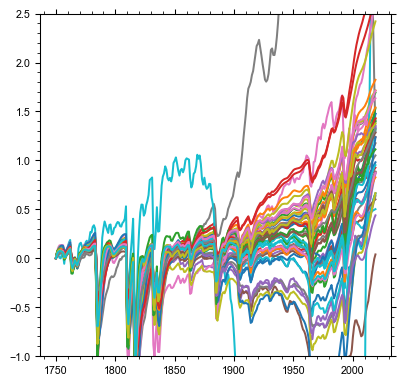

In [125]:
pl.plot(np.arange(1750,2020),output.filter(variable='Surface Temperature|Upper').timeseries().values.T);
pl.ylim(-1, 2.5)

In [28]:
output.timeseries()

time                                                                                                                                                                                                                                                                   1750-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter)  du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / kelvin / meter ** 2) model     region run_id run_idx scenario unit       variable                                  
0.0                                               two_layer     947.576917  41.092349  1.653388                 0.602535                         1.252392                             idealised World  0      0       ssp245   W/m^2      Effective Radiative Forcing    0.279801   
                                                                                                                                                                                                                               delta_degC Surface Temperature|Upper      0.000000   
                                                                                                                                                                                                                                          Surface Temperature|Lower      0.000000   
                                                                                                                                                                                                                               W/m^2      Heat Uptake                    0.000000   
                                                                902.560481  66.032113  1.288612                 0.575039                         1.115789                             idealised World  1      0       ssp245   W/m^2      Effective Radiative Forcing    0.279801   
...                                                                                                                                                                                                                                                                           ...   
                                                                783.220270  42.895107  1.251764                 0.770065                         1.318808                             idealised World  498    0       ssp245   W/m^2      Heat Uptake                    0.000000   
                                                                1192.437650 32.620687  1.663539                 0.682034                         1.372015                             idealised World  499    0       ssp245   W/m^2      Effective Radiative Forcing    0.279801   
                                                                                                                                                                                                                               delta_degC Surface Temperature|Upper      0.000000   
                                                                                                                                                                                                                                          Surface Temperature|Lower      0.000000   
                                                                                                                                                                                                                               W/m^2      Heat Uptake                    0.000000   

time                                                                                                                                                                                                                                                                   1751-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter)  du (meter) efficacy (dimensionless) eta (watt

In [35]:
temp_temp = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/20200727_paper_submitted/temp.h5')
temp_temp

/nfs/b0110/Users/mencsm/ar6/src/ar6/utils/h5.py:43: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


{'CMIP6-ECLIPSE': array([[-0.24399575, -0.68504772, -0.17162719, ..., -0.0533748 ,
         -0.03786312,  0.09130719],
        [-0.23102217, -0.67698418, -0.15490372, ..., -0.03837277,
         -0.02053662,  0.11416218],
        [-0.21981404, -0.67054839, -0.13771667, ..., -0.02415877,
         -0.00325364,  0.13935267],
        ...,
        [ 0.61832097,  1.88919793,  1.79681922, ...,  1.01536391,
          1.00529316,  1.97253266],
        [ 0.64956558,  1.89076409,  1.83669115, ...,  1.03943263,
          1.04712007,  2.03175022],
        [ 0.6810207 ,  1.89485159,  1.87549047, ...,  1.06194707,
          1.08737446,  2.088707  ]]),
 'CMIP6-constrained': array([[ 0.47919879,  0.1103899 , -0.17823142, ..., -0.07099673,
         -0.05621992, -0.07294894],
        [ 0.51082926,  0.1312442 , -0.16158003, ..., -0.05634795,
         -0.03900007, -0.05219694],
        [ 0.54483641,  0.15441485, -0.14448506, ..., -0.04255379,
         -0.02184737, -0.02976599],
        ...,
        [ 0.5822

In [37]:
temp_temp['CMIP6-constrained'].shape

(270, 25000)

In [110]:


def simple_weight(obs, mod, sigma_D):
    veracity = np.exp(-(mod-obs)**2/sigma_D**2)
    similarity = 1 # I see no good reason to change this #
    ks_raw = veracity/similarity
    ks_raw[np.isnan(ks_raw)] = 0
    ks = ks_raw/np.sum(ks_raw)
    return ks

In [111]:
ks['temp']['CMIP6-ECLIPSE'] = knutti_score(Tobs, temp['CMIP6-ECLIPSE'][100:270,:] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['CMIP6-ECLIPSE'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['CMIP6-ECLIPSE'][268,:]-ohc['CMIP6-ECLIPSE'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['CMIP6-ECLIPSE'] = (ks['temp']['CMIP6-ECLIPSE']*ks['ohc']['CMIP6-ECLIPSE'])/(np.sum(ks['temp']['CMIP6-ECLIPSE']*ks['ohc']['CMIP6-ECLIPSE']))

In [112]:
# print(weighted_percentile(ERFari['CMIP6-ECLIPSE'][268,:]+ERFaci['CMIP6-ECLIPSE'][268,:], ks['temp']['CMIP6-ECLIPSE'], [.05,.17,.5,.83,.95]))
# #print(weighted_percentile(ERFari['CMIP6-ECLIPSE'][268,:]+ERFaci['CMIP6-ECLIPSE'][268,:], ks['aer']['CMIP6-ECLIPSE'], [.05,.17,.5,.83,.95]))
# print(weighted_percentile(ERFari['CMIP6-ECLIPSE'][268,:]+ERFaci['CMIP6-ECLIPSE'][268,:], ks['ohc']['CMIP6-ECLIPSE'], [.05,.17,.5,.83,.95]))
# print(weighted_percentile(ERFari['CMIP6-ECLIPSE'][268,:]+ERFaci['CMIP6-ECLIPSE'][268,:], ks['multi']['CMIP6-ECLIPSE'], [.05,.17,.5,.83,.95]))

## CEDS emissions

In [113]:
ERFari['CMIP6-constrained'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(aerocom([emissions_ssp245.loc[2005:2015,'BC'], emissions_ssp245.loc[2005:2015,'OC'], emissions_ssp245.loc[2005:2015,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]))
    ts1850 = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
    ts1750 = aerocom([emissions_ssp245.loc[1750,'BC'], emissions_ssp245.loc[1750,'OC'], emissions_ssp245.loc[1750,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
    ERFari['CMIP6-constrained'][:,i] = (
        aerocom([emissions_ssp245['BC'], emissions_ssp245['OC'], emissions_ssp245['SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
        - ts1750
    )/(ts2010-ts1850)*(ERFari_scale[i])

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [114]:
ERFaci['CMIP6-constrained'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(ghan([emissions_ssp245.loc[2005:2015,'SO2'], emissions_ssp245.loc[2005:2015,'BC']+emissions_ssp245.loc[2005:2015,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]))
    ts1850 = ghan([emissions_ssp245.loc[1850,'SO2'],emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
    ts1750 = ghan([emissions_ssp245.loc[1750,'SO2'],emissions_ssp245.loc[1750,'BC']+emissions_ssp245.loc[1750,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
    ERFaci['CMIP6-constrained'][:,i] = (
        ghan([emissions_ssp245['SO2'],emissions_ssp245['BC']+emissions_ssp245['OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
        - ts1750
    )/(ts2010-ts1850)*(ERFaci_scale[i])

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [115]:
set1 = np.squeeze(np.where(np.logical_and(
    1.001*(np.percentile((ERFari['CMIP6-constrained'][-1,:] + ERFaci['CMIP6-constrained'][-1,:]), 50))
    < (ERFari['CMIP6-constrained'][-1,:]+ERFaci['CMIP6-constrained'][-1,:]), (ERFari['CMIP6-constrained'][-1,:]+ERFaci['CMIP6-constrained'][-1,:]) < 
    0.999*(np.percentile((ERFari['CMIP6-constrained'][-1,:] + ERFaci['CMIP6-constrained'][-1,:]), 50)))))
set1

array([ 1396,  1771,  2240,  4094,  4210,  6024,  7230,  9185,  9494,
        9873, 10028, 13186, 15998, 16418, 17766, 18010, 18120, 18628,
       20456, 21206, 23095, 23306, 23544, 24862])

In [117]:
temp['CMIP6-SSP2-4.5'] = np.zeros((270, samples))
ohc['CMIP6-SSP2-4.5'] = np.zeros((270, samples))
hflux['CMIP6-SSP2-4.5'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['CMIP6-SSP2-4.5'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CMIP6-SSP2-4.5'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['CMIP6-SSP2-4.5'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['CMIP6-SSP2-4.5'][:,i] = out.ohc
    hflux['CMIP6-SSP2-4.5'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [118]:
ks['temp']['CMIP6-SSP2-4.5'] = knutti_score(Tobs, temp['CMIP6-SSP2-4.5'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['CMIP6-SSP2-4.5'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['CMIP6-SSP2-4.5'][268,:]-ohc['CMIP6-SSP2-4.5'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['CMIP6-SSP2-4.5'] = (ks['temp']['CMIP6-SSP2-4.5']*ks['ohc']['CMIP6-SSP2-4.5'])/(np.sum(ks['temp']['CMIP6-SSP2-4.5']*ks['ohc']['CMIP6-SSP2-4.5']))

In [119]:
print(weighted_percentile(ERFari['CMIP6-SSP2-4.5'][268,:]+ERFaci['CMIP6-SSP2-4.5'][268,:], ks['temp']['CMIP6-SSP2-4.5'][:], [.05,.16,.5,.84,.95]))
print(weighted_percentile(ERFari['CMIP6-SSP2-4.5'][268,:]+ERFaci['CMIP6-SSP2-4.5'][268,:], ks['ohc']['CMIP6-SSP2-4.5'][:], [.05,.16,.5,.84,.95]))
#print(weighted_percentile(ERFari['CMIP6-SSP2-4.5'][268,:]+ERFaci['CMIP6-SSP2-4.5'][268,:], ks['aer']['CMIP6-SSP2-4.5'], [.05,.17,.5,.83,.95]))
print(weighted_percentile(ERFari['CMIP6-SSP2-4.5'][268,:]+ERFaci['CMIP6-SSP2-4.5'][268,:], ks['multi']['CMIP6-SSP2-4.5'][:], [.05,.16,.5,.84,.95]))

[-1.5345821004734197, -1.2507774633574311, -0.8426719665668315, -0.5000852860147, -0.3043172600567781]
[-1.6404630007863088, -1.3817872033770247, -1.0010130133770243, -0.5806628595946478, -0.29847550307528187]
[-1.526901248144692, -1.2876339381181978, -0.9227238134282025, -0.581121290699067, -0.38775566077284]


In [120]:
# pl.hist(10*(ohc['CMIP6-SSP2-4.5'][268,:]-ohc['CMIP6-SSP2-4.5'][221,:]), bins=np.arange(200,610,10), weights=ks['multi']['CMIP6-SSP2-4.5'], density=True);
# pl.plot(np.arange(200,600), st.norm.pdf(np.arange(200,600), loc=(OHCobs[58]-OHCobs[11])/1e21, scale=77.5/st.norm.ppf(0.95)), color='red')

## SSP3-70

In [121]:
# # temp hack - constrain SSP3-70 and SSP1-19 using SSP2-45

# ERFari['CMIP6-SSP3-7.0'] = np.zeros((270,samples))
# for i in range(samples):
#     ts2010 = np.mean(aerocom([emissions_ssp370.loc[2005:2015,'BC'], emissions_ssp370.loc[2005:2015,'OC'], emissions_ssp370.loc[2005:2015,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]))
#     ts1850 = aerocom([emissions_ssp370.loc[1850,'BC'], emissions_ssp370.loc[1850,'OC'], emissions_ssp370.loc[1850,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#     ts1750 = aerocom([emissions_ssp370.loc[1750,'BC'], emissions_ssp370.loc[1750,'OC'], emissions_ssp370.loc[1750,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#     ERFari['CMIP6-SSP3-7.0'][:,i] = (
#         aerocom([emissions_ssp370['BC'], emissions_ssp370['OC'], emissions_ssp370['SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#        - ts1750
#     )/(ts2010-ts1850)*(ERFari_scale[i])

# ERFaci['CMIP6-SSP3-7.0'] = np.zeros((270,samples))
# for i in range(samples):
#     ts2010 = np.mean(ghan([emissions_ssp370.loc[2005:2015,'SO2'], emissions_ssp370.loc[2005:2015,'BC']+emissions_ssp370.loc[2005:2015,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]))
#     ts1850 = ghan([emissions_ssp370.loc[1850,'SO2'],emissions_ssp370.loc[1850,'BC']+emissions_ssp370.loc[1850,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#     ts1750 = ghan([emissions_ssp370.loc[1750,'SO2'],emissions_ssp370.loc[1750,'BC']+emissions_ssp370.loc[1750,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#     ERFaci['CMIP6-SSP3-7.0'][:,i] = (
#         ghan([emissions_ssp370['SO2'],emissions_ssp370['BC']+emissions_ssp370['OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#         - ts1750
#     )/(ts2010-ts1850)*(ERFaci_scale[i])

### non-aerosol forcing is SSP2-4.5 still - is this what we want?

In [122]:
# temp['CMIP6-SSP3-7.0'] = np.zeros((270, samples))
# ohc['CMIP6-SSP3-7.0'] = np.zeros((270, samples))
# hflux['CMIP6-SSP3-7.0'] = np.zeros((270, samples))
# for i in tqdm_notebook(range(samples)):
# #for i in range(samples):
# #    if i%100==0:
# #        print(i)
#     in_forcing = baseline_forcing.copy()
#     in_forcing.drop(in_forcing.index[270:], inplace=True)
#     in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
#     in_forcing.set_index('year', inplace=True)
#     in_forcing * scale_df
#     in_forcing['aerosol-radiation_interactions'] = ERFari['CMIP6-SSP3-7.0'][:270,i]
#     in_forcing['aerosol-cloud_interactions'] = ERFaci['CMIP6-SSP3-7.0'][:270,i]
#     in_forcing['total'] = in_forcing.sum(axis=1)
#     #pl.plot(in_forcing['total'])
#     scm = scmpy.scmpy2l.ScmDef(
#         extforce=in_forcing['total'],
#         exttime=in_forcing.index,
#         tbeg=1750,
#         tend=2020,
#         q2x=geoff_sample_df.loc[i,'q4x']/2,
#         lamg=-geoff_sample_df.loc[i,'lamg'],
#         t2x=None,
#         eff=geoff_sample_df.loc[i,'eff'],
#         cmix=geoff_sample_df.loc[i,'cmix'],
#         cdeep=geoff_sample_df.loc[i,'cdeep'],
#         gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
#         outtime=np.arange(1750.5,2020),
#         dt=0.2
#     )
#     out = scm.run()
#     temp['CMIP6-SSP3-7.0'][:,i] = out.tg - np.mean(out.tg[100:150])
#     ohc['CMIP6-SSP3-7.0'][:,i] = out.ohc
#     hflux['CMIP6-SSP3-7.0'][:,i] = out.hflux

In [123]:
# ks['temp']['CMIP6-SSP3-7.0'] = knutti_score(Tobs, temp['CMIP6-SSP3-7.0'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
# ks['ohc']['CMIP6-SSP3-7.0'] = knutti_score(OHCobs/1e21, 10*(ohc['CMIP6-SSP3-7.0'][210:269,:]-ohc['CMIP6-SSP3-7.0'][210,:]), sigma_D=40)
# ks['multi']['CMIP6-SSP3-7.0'] = multi_knutti(
#     [Tobs, OHCobs/1e21],
#     [
#         temp['CMIP6-SSP3-7.0'][100:270, :] + intvar[100:270,:samples], 
#         10*(ohc['CMIP6-SSP3-7.0'][210:269,:]-ohc['CMIP6-SSP3-7.0'][210,:]), 
#     ], np.array([0.12, 40])
# )

## SSP1-1.9

In [124]:
# # temp hack - constrain SSP3-70 and SSP1-19 using SSP2-45

# ERFari['CMIP6-SSP1-1.9'] = np.zeros((270,samples))
# for i in range(samples):
#     ts2010 = np.mean(aerocom([emissions_ssp119.loc[2005:2015,'BC'], emissions_ssp119.loc[2005:2015,'OC'], emissions_ssp119.loc[2005:2015,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]))
#     ts1850 = aerocom([emissions_ssp119.loc[1850,'BC'], emissions_ssp119.loc[1850,'OC'], emissions_ssp119.loc[1850,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#     ts1750 = aerocom([emissions_ssp119.loc[1750,'BC'], emissions_ssp119.loc[1750,'OC'], emissions_ssp119.loc[1750,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#     ERFari['CMIP6-SSP1-1.9'][:,i] = (
#         aerocom([emissions_ssp119['BC'], emissions_ssp119['OC'], emissions_ssp119['SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
#         - ts1750
#     )/(ts2010-ts1850)*(ERFari_scale[i])

# ERFaci['CMIP6-SSP1-1.9'] = np.zeros((270,samples))
# for i in range(samples):
#     ts2010 = np.mean(ghan([emissions_ssp119.loc[2005:2015,'SO2'], emissions_ssp119.loc[2005:2015,'BC']+emissions_ssp119.loc[2005:2015,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]))
#     ts1850 = ghan([emissions_ssp119.loc[1850,'SO2'],emissions_ssp119.loc[1850,'BC']+emissions_ssp119.loc[1850,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#     ts1750 = ghan([emissions_ssp119.loc[1750,'SO2'],emissions_ssp119.loc[1750,'BC']+emissions_ssp119.loc[1750,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#     ERFaci['CMIP6-SSP1-1.9'][:,i] = (
#         ghan([emissions_ssp119['SO2'],emissions_ssp119['BC']+emissions_ssp119['OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
#         - ts1750
#     )/(ts2010-ts1850)*(ERFaci_scale[i])

### non-aerosol forcing is SSP2-4.5 still - is this what we want?

In [125]:
# temp['CMIP6-SSP1-1.9'] = np.zeros((270, samples))
# ohc['CMIP6-SSP1-1.9'] = np.zeros((270, samples))
# hflux['CMIP6-SSP1-1.9'] = np.zeros((270, samples))
# for i in tqdm_notebook(range(samples)):
# #for i in range(samples):
# #    if i%100==0:
# #        print(i)
#     in_forcing = baseline_forcing.copy()
#     in_forcing.drop(in_forcing.index[270:], inplace=True)
#     in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
#     in_forcing.set_index('year', inplace=True)
#     in_forcing * scale_df
#     in_forcing['aerosol-radiation_interactions'] = ERFari['CMIP6-SSP1-1.9'][:270,i]
#     in_forcing['aerosol-cloud_interactions'] = ERFaci['CMIP6-SSP1-1.9'][:270,i]
#     in_forcing['total'] = in_forcing.sum(axis=1)
#     #pl.plot(in_forcing['total'])
#     scm = scmpy.scmpy2l.ScmDef(
#         extforce=in_forcing['total'],
#         exttime=in_forcing.index,
#         tbeg=1750,
#         tend=2020,
#         q2x=geoff_sample_df.loc[i,'q4x']/2,
#         lamg=-geoff_sample_df.loc[i,'lamg'],
#         t2x=None,
#         eff=geoff_sample_df.loc[i,'eff'],
#         cmix=geoff_sample_df.loc[i,'cmix'],
#         cdeep=geoff_sample_df.loc[i,'cdeep'],
#         gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
#         outtime=np.arange(1750.5,2020),
#         dt=0.2
#     )
#     out = scm.run()
#     temp['CMIP6-SSP1-1.9'][:,i] = out.tg - np.mean(out.tg[100:150])
#     ohc['CMIP6-SSP1-1.9'][:,i] = out.ohc
#     hflux['CMIP6-SSP1-1.9'][:,i] = out.hflux

In [126]:
# ks['temp']['CMIP6-SSP1-1.9'] = knutti_score(Tobs, temp['CMIP6-SSP1-1.9'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
# ks['ohc']['CMIP6-SSP1-1.9'] = knutti_score(OHCobs/1e21, 10*(ohc['CMIP6-SSP1-1.9'][210:269,:]-ohc['CMIP6-SSP1-1.9'][210,:]), sigma_D=40)
# ks['multi']['CMIP6-SSP1-1.9'] = multi_knutti(
#     [Tobs, OHCobs/1e21],
#     [
#         temp['CMIP6-SSP1-1.9'][100:270, :] + intvar[100:270,:samples], 
#         10*(ohc['CMIP6-SSP1-1.9'][210:269,:]-ohc['CMIP6-SSP1-1.9'][210,:]), 
#     ], np.array([0.12, 40])
# )

## Lund

In [127]:
Lund2010ari = Lund_ERFari[255:265].mean()
Lund2010aci = Lund_ERFaci[255:265].mean()
Lund1850ari = Lund_ERFari[100]
Lund1850aci = Lund_ERFaci[100]
ERFari['Oslo-CTM3'] = np.zeros((270,samples_cmip6))
ERFaci['Oslo-CTM3'] = np.zeros((270,samples_cmip6))
for i in range(samples_cmip6):
    ERFaci['Oslo-CTM3'][:,i] = Lund_ERFaci[:270]/(Lund2010aci-Lund1850aci)*(ERFaci_scale[i])
    ERFari['Oslo-CTM3'][:,i] = Lund_ERFari[:270]/(Lund2010ari-Lund1850aci)*(ERFari_scale[i])

In [128]:
temp['Oslo-CTM3'] = np.zeros((270, samples_cmip6))
ohc['Oslo-CTM3'] = np.zeros((270, samples_cmip6))
hflux['Oslo-CTM3'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['Oslo-CTM3'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['Oslo-CTM3'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['Oslo-CTM3'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['Oslo-CTM3'][:,i] = out.ohc
    hflux['Oslo-CTM3'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [129]:
ks['temp']['Oslo-CTM3'] = knutti_score(Tobs, temp['Oslo-CTM3'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['Oslo-CTM3'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['Oslo-CTM3'][268,:]-ohc['Oslo-CTM3'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['Oslo-CTM3'] = (ks['temp']['Oslo-CTM3']*ks['ohc']['Oslo-CTM3'])/(np.sum(ks['temp']['Oslo-CTM3']*ks['ohc']['Oslo-CTM3']))

## AR5

In [130]:
# AR5_2010ari = AR5_ERFari[260]
# AR5_2010aci = AR5_ERFaci[260]
# AR5_1850ari = AR5_ERFari[100]
# AR5_1850aci = AR5_ERFaci[100]
# ERFari['AR5'] = np.zeros((270,samples))
# ERFaci['AR5'] = np.zeros((270,samples))
# for i in range(samples):
#     ERFaci['AR5'][:,i] = AR5_ERFaci[:270]/(AR5_2010aci-AR5_1850aci)*(ERFaci_scale[i])
#     ERFari['AR5'][:,i] = AR5_ERFari[:270]/(AR5_2010ari-AR5_1850aci)*(ERFari_scale[i])

In [131]:
# temp['AR5'] = np.zeros((270, samples))
# ohc['AR5'] = np.zeros((270, samples))
# hflux['AR5'] = np.zeros((270, samples))
# for i in tqdm_notebook(range(samples)):
#     in_forcing = baseline_forcing.copy()
#     in_forcing.drop(in_forcing.index[270:], inplace=True)
#     in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
#     in_forcing.set_index('year', inplace=True)
#     in_forcing * scale_df
#     in_forcing['aerosol-radiation_interactions'] = ERFari['AR5'][:270,i]
#     in_forcing['aerosol-cloud_interactions'] = ERFaci['AR5'][:270,i]
#     in_forcing['total'] = in_forcing.sum(axis=1)
#     #pl.plot(in_forcing['total'])
#     scm = scmpy.scmpy2l.ScmDef(
#         extforce=in_forcing['total'],
#         exttime=in_forcing.index,
#         tbeg=1750,
#         tend=2020,
#         q2x=geoff_sample_df.loc[i,'q4x']/2,
#         lamg=-geoff_sample_df.loc[i,'lamg'],
#         t2x=None,
#         eff=geoff_sample_df.loc[i,'eff'],
#         cmix=geoff_sample_df.loc[i,'cmix'],
#         cdeep=geoff_sample_df.loc[i,'cdeep'],
#         gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
#         outtime=np.arange(1750.5,2020),
#         dt=0.2
#     )
#     out = scm.run()
#     temp['AR5'][:,i] = out.tg - np.mean(out.tg[100:150])
#     ohc['AR5'][:,i] = out.ohc
#     hflux['AR5'][:,i] = out.hflux


In [132]:
# ks['temp']['AR5'] = knutti_score(Tobs, temp['AR5'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
# ks['ohc']['AR5'] = knutti_score(OHCobs/1e21, 10*(ohc['AR5'][210:269,:]-ohc['AR5'][210,:]), sigma_D=40)
# #ks['multi']['AR5'] = 0.5*(ks['temp']['AR5']+ks['ohc']['AR5'])
# ks['multi']['AR5'] = multi_knutti([Tobs, OHCobs/1e21], [temp['AR5'][100:270, :] + intvar[100:270,:samples], 10*(ohc['AR5'][210:269,:]-ohc['AR5'][210,:])], np.array([0.12, 40]))
# #ks['ohc']['AR5'] = weight_gauss(OHCobs[-1]/1e21, 10*(ohc['AR5'][268,:]-ohc['AR5'][210,:]), 40)

In [133]:
with open("../data/cmip6_aerosol_coefficients.json", "r") as read_file:
    aero_coeffs = json.load(read_file)

aero_coeffs

{'CanESM5': {'ERFari': {'BC': 0.03261148843683754,
   'OC': -0.0003518848417633737,
   'SO2': -0.0049707840262622005},
  'ERFariSW': {'BC': 0.033179680319599475,
   'OC': 0.004892455399943645,
   'SO2': -0.008171920257560032},
  'ERFariLW': {'BC': -0.0005682077766655685,
   'OC': -0.005244335402605431,
   'SO2': 0.0032011367521301466},
  'ERFaci': {'beta': 0.7271842343917729,
   'n0': 29.475252826922958,
   'n1': 24.62663259817772},
  'ERFaciSW': {'beta': 0.5956852307011665,
   'n0': 19.481733815942132,
   'n1': 29.74275701811797},
  'ERFaciLW': {'BC': -0.007373184921305589,
   'OC': -0.005440827225957521,
   'SO2': 0.001282453720405149}},
 'E3SM': {'ERFari': {'BC': 0.024806197235746178,
   'OC': -0.012625521431328298,
   'SO2': -0.0018819956102323807},
  'ERFariSW': {'BC': 0.011151799466432953,
   'OC': -0.010868533098411222,
   'SO2': -0.003921075758451751},
  'ERFariLW': {'BC': 0.01365438747575096,
   'OC': -0.0017569854235879247,
   'SO2': 0.002039080480616391},
  'ERFaci': {'beta'

## GFDL-ESM4

In [134]:
GFDLESM2010ari = GFDLESM_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GFDLESM_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GFDLESM2010aci = GFDLESM_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GFDLESM_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GFDL-ESM4'] = np.zeros((270,samples_cmip6))
ERFaci['GFDL-ESM4'] = np.zeros((270,samples_cmip6))
GFDLESMari = np.zeros(270)
GFDLESMaci = np.zeros(270)
GFDLESMari[100:265] = GFDLESM_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+GFDLESM_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
GFDLESMaci[100:265] = GFDLESM_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+GFDLESM_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1'])
GFDLESMari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2']) - ts1850ari
GFDLESMaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1']) - ts1850aci
#GFDLESMari[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='GFDL-ESM4')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='GFDL-ESM4')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariLW'].values[0]
#GFDLESMaci[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='GFDL-ESM4')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='GFDL-ESM4')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciLW'].values[0]
GFDLESMari[265:] = aerocom([emissions_ssp245.loc[2015:2019,'BC'], emissions_ssp245.loc[2015:2019,'OC'], emissions_ssp245.loc[2015:2019,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2']) - ts1850ari
GFDLESMaci[265:] = ghan([emissions_ssp245.loc[2015:2019,'SO2'], emissions_ssp245.loc[2015:2019,'BC']+emissions_ssp245.loc[2015:2019,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['GFDL-ESM4'][:,i] = (GFDLESMaci-GFDLESMaci[0])/GFDLESM2010aci*(ERFaci_scale[i])
    ERFari['GFDL-ESM4'][:,i] = (GFDLESMari-GFDLESMari[0])/GFDLESM2010ari*(ERFari_scale[i])

In [135]:
temp['GFDL-ESM4'] = np.zeros((270, samples_cmip6))
ohc['GFDL-ESM4'] = np.zeros((270, samples_cmip6))
hflux['GFDL-ESM4'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['GFDL-ESM4'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GFDL-ESM4'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GFDL-ESM4'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GFDL-ESM4'][:,i] = out.ohc
    hflux['GFDL-ESM4'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [136]:
ks['temp']['GFDL-ESM4'] = knutti_score(Tobs, temp['GFDL-ESM4'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['GFDL-ESM4'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['GFDL-ESM4'][268,:]-ohc['GFDL-ESM4'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['GFDL-ESM4'] = (ks['temp']['GFDL-ESM4']*ks['ohc']['GFDL-ESM4'])/(np.sum(ks['temp']['GFDL-ESM4']*ks['ohc']['GFDL-ESM4']))

## UKESM1-0-LL

In [137]:
UKESM2010ari = UKESM_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+UKESM_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
UKESM2010aci = UKESM_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+UKESM_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['UKESM1-0-LL'] = np.zeros((270,samples_cmip6))
ERFaci['UKESM1-0-LL'] = np.zeros((270,samples_cmip6))
UKESMari = np.zeros(270)
UKESMaci = np.zeros(270)
UKESMari[100:265] = UKESM_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+UKESM_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
UKESMaci[100:265] = UKESM_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+UKESM_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1'])
UKESMari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2']) - ts1850ari
UKESMaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1']) - ts1850aci
#UKESMari[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='UKESM1-0-LL')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='UKESM1-0-LL')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariLW'].values[0]
#UKESMaci[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='UKESM1-0-LL')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='UKESM1-0-LL')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciLW'].values[0]
UKESMari[265:] = aerocom([emissions_ssp245.loc[2015:2019,'BC'], emissions_ssp245.loc[2015:2019,'OC'], emissions_ssp245.loc[2015:2019,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2']) - ts1850ari
UKESMaci[265:] = ghan([emissions_ssp245.loc[2015:2019,'SO2'], emissions_ssp245.loc[2015:2019,'BC']+emissions_ssp245.loc[2015:2019,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['UKESM1-0-LL'][:,i] = (UKESMaci-UKESMaci[0])/UKESM2010aci*(ERFaci_scale[i])
    ERFari['UKESM1-0-LL'][:,i] = (UKESMari-UKESMari[0])/UKESM2010ari*(ERFari_scale[i])

In [138]:
temp['UKESM1-0-LL'] = np.zeros((270, samples_cmip6))
ohc['UKESM1-0-LL'] = np.zeros((270, samples_cmip6))
hflux['UKESM1-0-LL'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['UKESM1-0-LL'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['UKESM1-0-LL'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['UKESM1-0-LL'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['UKESM1-0-LL'][:,i] = out.ohc
    hflux['UKESM1-0-LL'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [139]:
ks['temp']['UKESM1-0-LL'] = knutti_score(Tobs, temp['UKESM1-0-LL'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['UKESM1-0-LL'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['UKESM1-0-LL'][268,:]-ohc['UKESM1-0-LL'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['UKESM1-0-LL'] = (ks['temp']['UKESM1-0-LL']*ks['ohc']['UKESM1-0-LL'])/(np.sum(ks['temp']['UKESM1-0-LL']*ks['ohc']['UKESM1-0-LL']))

## CanESM5

In [140]:
CanESM2010ari = CanESM5_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+CanESM5_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
CanESM2010aci = CanESM5_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+CanESM5_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['CanESM5'] = np.zeros((270,samples_cmip6))
ERFaci['CanESM5'] = np.zeros((270,samples_cmip6))
CanESMari = np.zeros(270)
CanESMaci = np.zeros(270)
CanESMari[100:] = CanESM5_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+CanESM5_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
CanESMaci[100:] = CanESM5_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+CanESM5_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['CanESM5']['ERFari']['BC'], aero_coeffs['CanESM5']['ERFari']['OC'], aero_coeffs['CanESM5']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['CanESM5']['ERFaci']['beta'], aero_coeffs['CanESM5']['ERFaci']['n0'], aero_coeffs['CanESM5']['ERFaci']['n1'])
CanESMari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['CanESM5']['ERFari']['BC'], aero_coeffs['CanESM5']['ERFari']['OC'], aero_coeffs['CanESM5']['ERFari']['SO2']) - ts1850ari
CanESMaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['CanESM5']['ERFaci']['beta'], aero_coeffs['CanESM5']['ERFaci']['n0'], aero_coeffs['CanESM5']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['CanESM5'][:,i] = (CanESMaci-CanESMaci[0])/CanESM2010aci*(ERFaci_scale[i])
    ERFari['CanESM5'][:,i] = (CanESMari-CanESMari[0])/CanESM2010ari*(ERFari_scale[i])

In [141]:
temp['CanESM5'] = np.zeros((270, samples_cmip6))
ohc['CanESM5'] = np.zeros((270, samples_cmip6))
hflux['CanESM5'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['CanESM5'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CanESM5'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['CanESM5'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['CanESM5'][:,i] = out.ohc
    hflux['CanESM5'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [142]:
ks['temp']['CanESM5'] = knutti_score(Tobs, temp['CanESM5'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['CanESM5'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['CanESM5'][268,:]-ohc['CanESM5'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['CanESM5'] = (ks['temp']['CanESM5']*ks['ohc']['CanESM5'])/(np.sum(ks['temp']['CanESM5']*ks['ohc']['CanESM5']))

## E3SM

In [143]:
# take 05-14 mean for E3SM
E3SM2010ari = E3SM_aerforcing.loc[135:144,'aprp_ERFariSW'].mean()+E3SM_aerforcing.loc[135:144,'aprp_ERFariLW'].mean()
E3SM2010aci = E3SM_aerforcing.loc[135:144,'aprp_ERFaciSW'].mean()+E3SM_aerforcing.loc[135:144,'aprp_ERFaciLW'].mean()
ERFari['E3SM'] = np.zeros((270,samples_cmip6))
ERFaci['E3SM'] = np.zeros((270,samples_cmip6))
E3SMari = np.zeros(270)
E3SMaci = np.zeros(270)
E3SMari[120:265] = E3SM_aerforcing.loc[0:145, 'aprp_ERFariSW'].values+E3SM_aerforcing.loc[0:145, 'aprp_ERFariLW'].values
E3SMaci[120:265] = E3SM_aerforcing.loc[0:145, 'aprp_ERFaciSW'].values+E3SM_aerforcing.loc[0:145, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1'])
E3SMari[:120] = aerocom([emissions_ssp245.loc[1750:1869,'BC'], emissions_ssp245.loc[1750:1869,'OC'], emissions_ssp245.loc[1750:1869,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2']) - ts1850ari
E3SMaci[:120] = ghan([emissions_ssp245.loc[1750:1869,'SO2'], emissions_ssp245.loc[1750:1869,'BC']+emissions_ssp245.loc[1750:1869,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1']) - ts1850aci
E3SMari[265:] = aerocom([emissions_ssp245.loc[2015:2019,'BC'], emissions_ssp245.loc[2015:2019,'OC'], emissions_ssp245.loc[2015:2019,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2']) - ts1850ari
E3SMaci[265:] = ghan([emissions_ssp245.loc[2015:2019,'SO2'], emissions_ssp245.loc[2015:2019,'BC']+emissions_ssp245.loc[2015:2019,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['E3SM'][:,i] = (E3SMaci-E3SMaci[0])/E3SM2010aci*(ERFaci_scale[i])
    ERFari['E3SM'][:,i] = (E3SMari-E3SMari[0])/E3SM2010ari*(ERFari_scale[i])

In [144]:
temp['E3SM'] = np.zeros((270, samples_cmip6))
ohc['E3SM'] = np.zeros((270, samples_cmip6))
hflux['E3SM'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['E3SM'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['E3SM'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=0.2
    )
    out = scm.run()
    temp['E3SM'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['E3SM'][:,i] = out.ohc
    hflux['E3SM'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [145]:
ks['temp']['E3SM'] = knutti_score(Tobs, temp['E3SM'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['E3SM'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['E3SM'][268,:]-ohc['E3SM'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['E3SM'] = (ks['temp']['E3SM']*ks['ohc']['E3SM'])/(np.sum(ks['temp']['E3SM']*ks['ohc']['E3SM']))

## GFDL-CM4

In [146]:
GFDL2010ari = GFDL_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GFDL_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GFDL2010aci = GFDL_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GFDL_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GFDL-CM4'] = np.zeros((270,samples_cmip6))
ERFaci['GFDL-CM4'] = np.zeros((270,samples_cmip6))
GFDLari = np.zeros(270)
GFDLaci = np.zeros(270)
GFDLari[100:] = GFDL_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+GFDL_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
GFDLaci[100:] = GFDL_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+GFDL_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['GFDL-CM4']['ERFari']['BC'], aero_coeffs['GFDL-CM4']['ERFari']['OC'], aero_coeffs['GFDL-CM4']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['GFDL-CM4']['ERFaci']['beta'], aero_coeffs['GFDL-CM4']['ERFaci']['n0'], aero_coeffs['GFDL-CM4']['ERFaci']['n1'])
GFDLari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['GFDL-CM4']['ERFari']['BC'], aero_coeffs['GFDL-CM4']['ERFari']['OC'], aero_coeffs['GFDL-CM4']['ERFari']['SO2']) - ts1850ari
GFDLaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['GFDL-CM4']['ERFaci']['beta'], aero_coeffs['GFDL-CM4']['ERFaci']['n0'], aero_coeffs['GFDL-CM4']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['GFDL-CM4'][:,i] = (GFDLaci-CanESMaci[0])/GFDL2010aci*(ERFaci_scale[i])
    ERFari['GFDL-CM4'][:,i] = (GFDLari-CanESMari[0])/GFDL2010ari*(ERFari_scale[i])

In [147]:
temp['GFDL-CM4'] = np.zeros((270, samples_cmip6))
ohc['GFDL-CM4'] = np.zeros((270, samples_cmip6))
hflux['GFDL-CM4'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['GFDL-CM4'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GFDL-CM4'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GFDL-CM4'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GFDL-CM4'][:,i] = out.ohc
    hflux['GFDL-CM4'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [148]:
ks['temp']['GFDL-CM4'] = knutti_score(Tobs, temp['GFDL-CM4'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['GFDL-CM4'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['GFDL-CM4'][268,:]-ohc['GFDL-CM4'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['GFDL-CM4'] = (ks['temp']['GFDL-CM4']*ks['ohc']['GFDL-CM4'])/(np.sum(ks['temp']['GFDL-CM4']*ks['ohc']['GFDL-CM4']))

## GISS-E2-1-G

In [149]:
GISS2010ari = GISS_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GISS_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GISS2010aci = GISS_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GISS_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GISS-E2-1-G'] = np.zeros((270,samples_cmip6))
ERFaci['GISS-E2-1-G'] = np.zeros((270,samples_cmip6))
GISSari = np.zeros(270)
GISSaci = np.zeros(270)
GISSari[100:] = GISS_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+GISS_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
GISSaci[100:] = GISS_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+GISS_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['GISS-E2-1-G']['ERFari']['BC'], aero_coeffs['GISS-E2-1-G']['ERFari']['OC'], aero_coeffs['GISS-E2-1-G']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['GISS-E2-1-G']['ERFaci']['beta'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n0'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n1'])
GISSari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['GISS-E2-1-G']['ERFari']['BC'], aero_coeffs['GISS-E2-1-G']['ERFari']['OC'], aero_coeffs['GISS-E2-1-G']['ERFari']['SO2']) - ts1850ari
GISSaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['GISS-E2-1-G']['ERFaci']['beta'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n0'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['GISS-E2-1-G'][:,i] = (GISSaci-GISSaci[0])/GISS2010aci*(ERFaci_scale[i])
    ERFari['GISS-E2-1-G'][:,i] = (GISSari-GISSari[0])/GISS2010ari*(ERFari_scale[i])

In [150]:
temp['GISS-E2-1-G'] = np.zeros((270, samples_cmip6))
ohc['GISS-E2-1-G'] = np.zeros((270, samples_cmip6))
hflux['GISS-E2-1-G'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['GISS-E2-1-G'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GISS-E2-1-G'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GISS-E2-1-G'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GISS-E2-1-G'][:,i] = out.ohc
    hflux['GISS-E2-1-G'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [151]:
ks['temp']['GISS-E2-1-G'] = knutti_score(Tobs, temp['GISS-E2-1-G'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['GISS-E2-1-G'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['GISS-E2-1-G'][268,:]-ohc['GISS-E2-1-G'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['GISS-E2-1-G'] = (ks['temp']['GISS-E2-1-G']*ks['ohc']['GISS-E2-1-G'])/(np.sum(ks['temp']['GISS-E2-1-G']*ks['ohc']['GISS-E2-1-G']))

## IPSL-CM6A-LR

In [152]:
IPSL2010ari = IPSL_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+IPSL_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
IPSL2010aci = IPSL_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+IPSL_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['IPSL-CM6A-LR'] = np.zeros((270,samples_cmip6))
ERFaci['IPSL-CM6A-LR'] = np.zeros((270,samples_cmip6))
IPSLari = np.zeros(270)
IPSLaci = np.zeros(270)
IPSLari[100:] = IPSL_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+IPSL_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
IPSLaci[100:] = IPSL_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+IPSL_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['IPSL-CM6A-LR']['ERFari']['BC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['OC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['beta'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n0'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n1'])
IPSLari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['IPSL-CM6A-LR']['ERFari']['BC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['OC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['SO2']) - ts1850ari
IPSLaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['beta'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n0'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['IPSL-CM6A-LR'][:,i] = (IPSLaci-IPSLaci[0])/IPSL2010aci*(ERFaci_scale[i])
    ERFari['IPSL-CM6A-LR'][:,i] = (IPSLari-IPSLari[0])/IPSL2010ari*(ERFari_scale[i])

In [153]:
temp['IPSL-CM6A-LR'] = np.zeros((270, samples_cmip6))
ohc['IPSL-CM6A-LR'] = np.zeros((270, samples_cmip6))
hflux['IPSL-CM6A-LR'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['IPSL-CM6A-LR'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['IPSL-CM6A-LR'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['IPSL-CM6A-LR'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['IPSL-CM6A-LR'][:,i] = out.ohc
    hflux['IPSL-CM6A-LR'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [154]:
ks['temp']['IPSL-CM6A-LR'] = knutti_score(Tobs, temp['IPSL-CM6A-LR'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['IPSL-CM6A-LR'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['IPSL-CM6A-LR'][268,:]-ohc['IPSL-CM6A-LR'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['IPSL-CM6A-LR'] = (ks['temp']['IPSL-CM6A-LR']*ks['ohc']['IPSL-CM6A-LR'])/(np.sum(ks['temp']['IPSL-CM6A-LR']*ks['ohc']['IPSL-CM6A-LR']))

## MIROC6

In [155]:
MIROC2010ari = MIROC6_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+MIROC6_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
MIROC2010aci = MIROC6_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+MIROC6_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['MIROC6'] = np.zeros((270,samples_cmip6))
ERFaci['MIROC6'] = np.zeros((270,samples_cmip6))
MIROCari = np.zeros(270)
MIROCaci = np.zeros(270)
MIROCari[100:] = MIROC6_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+MIROC6_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
MIROCaci[100:] = MIROC6_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+MIROC6_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['MIROC6']['ERFari']['BC'], aero_coeffs['MIROC6']['ERFari']['OC'], aero_coeffs['MIROC6']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['MIROC6']['ERFaci']['beta'], aero_coeffs['MIROC6']['ERFaci']['n0'], aero_coeffs['MIROC6']['ERFaci']['n1'])
MIROCari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['MIROC6']['ERFari']['BC'], aero_coeffs['MIROC6']['ERFari']['OC'], aero_coeffs['MIROC6']['ERFari']['SO2']) - ts1850ari
MIROCaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['MIROC6']['ERFaci']['beta'], aero_coeffs['MIROC6']['ERFaci']['n0'], aero_coeffs['MIROC6']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['MIROC6'][:,i] = (MIROCaci-MIROCaci[0])/MIROC2010aci*(ERFaci_scale[i])
    ERFari['MIROC6'][:,i] = (MIROCari-MIROCari[0])/MIROC2010ari*(ERFari_scale[i])

In [156]:
temp['MIROC6'] = np.zeros((270, samples_cmip6))
ohc['MIROC6'] = np.zeros((270, samples_cmip6))
hflux['MIROC6'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['MIROC6'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['MIROC6'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['MIROC6'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['MIROC6'][:,i] = out.ohc
    hflux['MIROC6'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [157]:
ks['temp']['MIROC6'] = knutti_score(Tobs, temp['MIROC6'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['MIROC6'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['MIROC6'][268,:]-ohc['MIROC6'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['MIROC6'] = (ks['temp']['MIROC6']*ks['ohc']['MIROC6'])/(np.sum(ks['temp']['MIROC6']*ks['ohc']['MIROC6']))

## NorESM2

In [158]:
NorESM2010ari = NorESM2_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+NorESM2_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
NorESM2010aci = NorESM2_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+NorESM2_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['NorESM2-LM'] = np.zeros((270,samples_cmip6))
ERFaci['NorESM2-LM'] = np.zeros((270,samples_cmip6))
NorESMari = np.zeros(270)
NorESMaci = np.zeros(270)
NorESMari[100:265] = NorESM2_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+NorESM2_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
NorESMaci[100:265] = NorESM2_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+NorESM2_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['NorESM2-LM']['ERFari']['BC'], aero_coeffs['NorESM2-LM']['ERFari']['OC'], aero_coeffs['NorESM2-LM']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['NorESM2-LM']['ERFaci']['beta'], aero_coeffs['NorESM2-LM']['ERFaci']['n0'], aero_coeffs['NorESM2-LM']['ERFaci']['n1'])
NorESMari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['NorESM2-LM']['ERFari']['BC'], aero_coeffs['NorESM2-LM']['ERFari']['OC'], aero_coeffs['NorESM2-LM']['ERFari']['SO2']) - ts1850ari
NorESMaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['NorESM2-LM']['ERFaci']['beta'], aero_coeffs['NorESM2-LM']['ERFaci']['n0'], aero_coeffs['NorESM2-LM']['ERFaci']['n1']) - ts1850aci
#NorESMari[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='NorESM2-LM')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='NorESM2-LM')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFariLW'].values[0]
#NorESMaci[265:] = RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='NorESM2-LM')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciSW'].values[0]+RFMIP_aerforcing[(RFMIP_aerforcing['Model']=='NorESM2-LM')&(RFMIP_aerforcing['Run']=='r1i1p1f1')]['ERFaciLW'].values[0]
NorESMari[265:] = aerocom([emissions_ssp245.loc[2015:2019,'BC'], emissions_ssp245.loc[2015:2019,'OC'], emissions_ssp245.loc[2015:2019,'SO2']], aero_coeffs['NorESM2-LM']['ERFari']['BC'], aero_coeffs['NorESM2-LM']['ERFari']['OC'], aero_coeffs['NorESM2-LM']['ERFari']['SO2']) - ts1850ari
NorESMaci[265:] = ghan([emissions_ssp245.loc[2015:2019,'SO2'], emissions_ssp245.loc[2015:2019,'BC']+emissions_ssp245.loc[2015:2019,'OC']], aero_coeffs['NorESM2-LM']['ERFaci']['beta'], aero_coeffs['NorESM2-LM']['ERFaci']['n0'], aero_coeffs['NorESM2-LM']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['NorESM2-LM'][:,i] = (NorESMaci-NorESMaci[0])/NorESM2010aci*(ERFaci_scale[i])
    ERFari['NorESM2-LM'][:,i] = (NorESMari-NorESMari[0])/NorESM2010ari*(ERFari_scale[i])

In [159]:
temp['NorESM2-LM'] = np.zeros((270, samples_cmip6))
ohc['NorESM2-LM'] = np.zeros((270, samples_cmip6))
hflux['NorESM2-LM'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['NorESM2-LM'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['NorESM2-LM'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['NorESM2-LM'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['NorESM2-LM'][:,i] = out.ohc
    hflux['NorESM2-LM'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [160]:
ks['temp']['NorESM2-LM'] = knutti_score(Tobs, temp['NorESM2-LM'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['NorESM2-LM'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['NorESM2-LM'][268,:]-ohc['NorESM2-LM'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['NorESM2-LM'] = (ks['temp']['NorESM2-LM']*ks['ohc']['NorESM2-LM'])/(np.sum(ks['temp']['NorESM2-LM']*ks['ohc']['NorESM2-LM']))

## HadGEM3-GC31-LL

In [161]:
HadGEM2010ari = HadGEM3_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+HadGEM3_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
HadGEM2010aci = HadGEM3_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+HadGEM3_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['HadGEM3-GC31-LL'] = np.zeros((270,samples_cmip6))
ERFaci['HadGEM3-GC31-LL'] = np.zeros((270,samples_cmip6))
HadGEMari = np.zeros(270)
HadGEMaci = np.zeros(270)
HadGEMari[100:] = HadGEM3_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+HadGEM3_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
HadGEMaci[100:] = HadGEM3_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+HadGEM3_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions_ssp245.loc[1850,'BC'], emissions_ssp245.loc[1850,'OC'], emissions_ssp245.loc[1850,'SO2']], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['BC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['OC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['SO2'])
ts1850aci = ghan([emissions_ssp245.loc[1850,'SO2'], emissions_ssp245.loc[1850,'BC']+emissions_ssp245.loc[1850,'OC']], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['beta'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n0'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n1'])
HadGEMari[:100] = aerocom([emissions_ssp245.loc[1750:1849,'BC'], emissions_ssp245.loc[1750:1849,'OC'], emissions_ssp245.loc[1750:1849,'SO2']], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['BC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['OC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['SO2']) - ts1850ari
HadGEMaci[:100] = ghan([emissions_ssp245.loc[1750:1849,'SO2'], emissions_ssp245.loc[1750:1849,'BC']+emissions_ssp245.loc[1750:1849,'OC']], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['beta'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n0'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n1']) - ts1850aci
for i in range(samples_cmip6):
    ERFaci['HadGEM3-GC31-LL'][:,i] = (HadGEMaci-HadGEMaci[0])/HadGEM2010aci*(ERFaci_scale[i])
    ERFari['HadGEM3-GC31-LL'][:,i] = (HadGEMari-HadGEMari[0])/HadGEM2010ari*(ERFari_scale[i])

In [162]:
temp['HadGEM3-GC31-LL'] = np.zeros((270, samples_cmip6))
ohc['HadGEM3-GC31-LL'] = np.zeros((270, samples_cmip6))
hflux['HadGEM3-GC31-LL'] = np.zeros((270, samples_cmip6))
for i in tqdm_notebook(range(samples_cmip6)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['HadGEM3-GC31-LL'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['HadGEM3-GC31-LL'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    #pl.plot(in_forcing['total'])
    scm = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['HadGEM3-GC31-LL'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['HadGEM3-GC31-LL'][:,i] = out.ohc
    hflux['HadGEM3-GC31-LL'][:,i] = out.hflux

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [163]:
ks['temp']['HadGEM3-GC31-LL'] = knutti_score(Tobs, temp['HadGEM3-GC31-LL'][100:270, :] + intvar[100:270,:samples_cmip6], sigma_D=0.12)
ks['ohc']['HadGEM3-GC31-LL'] = simple_weight((OHCobs[58]-OHCobs[11])/1e21, 10*(ohc['HadGEM3-GC31-LL'][268,:]-ohc['HadGEM3-GC31-LL'][221,:]), sigma_D=77.5/st.norm.ppf(0.95))
ks['multi']['HadGEM3-GC31-LL'] = (ks['temp']['HadGEM3-GC31-LL']*ks['ohc']['HadGEM3-GC31-LL'])/(np.sum(ks['temp']['HadGEM3-GC31-LL']*ks['ohc']['HadGEM3-GC31-LL']))

In [164]:
ERFari['CMIP6-constrained'] = ERFari.pop('CMIP6-SSP2-4.5')
ERFaci['CMIP6-constrained'] = ERFaci.pop('CMIP6-SSP2-4.5')
temp['CMIP6-constrained'] = temp.pop('CMIP6-SSP2-4.5')
ohc['CMIP6-constrained'] = ohc.pop('CMIP6-SSP2-4.5')
hflux['CMIP6-constrained'] = hflux.pop('CMIP6-SSP2-4.5')
ks['temp']['CMIP6-constrained'] = ks['temp'].pop('CMIP6-SSP2-4.5')
ks['ohc']['CMIP6-constrained'] = ks['ohc'].pop('CMIP6-SSP2-4.5')
ks['multi']['CMIP6-constrained'] = ks['multi'].pop('CMIP6-SSP2-4.5')

In [40]:
# ERFari['ECLIPSE-constrained'] = ERFari.pop('CMIP6-ECLIPSE')
# ERFaci['ECLIPSE-constrained'] = ERFaci.pop('CMIP6-ECLIPSE')
# temp['ECLIPSE-constrained'] = temp.pop('CMIP6-ECLIPSE')
# ohc['ECLIPSE-constrained'] = ohc.pop('CMIP6-ECLIPSE')
# hflux['ECLIPSE-constrained'] = hflux.pop('CMIP6-ECLIPSE')
# ks['temp']['ECLIPSE-constrained'] = ks['temp'].pop('CMIP6-ECLIPSE')
# ks['ohc']['ECLIPSE-constrained'] = ks['ohc'].pop('CMIP6-ECLIPSE')
# ks['multi']['ECLIPSE-constrained'] = ks['multi'].pop('CMIP6-ECLIPSE')

In [165]:
save_dict_to_hdf5(ERFari, '/nfs/a65/pmcjs/AR6_tuning/aerosols/ERFari.h5')
save_dict_to_hdf5(ERFaci, '/nfs/a65/pmcjs/AR6_tuning/aerosols/ERFaci.h5')
save_dict_to_hdf5(temp, '/nfs/a65/pmcjs/AR6_tuning/aerosols/temp.h5')
save_dict_to_hdf5(ks, '/nfs/a65/pmcjs/AR6_tuning/aerosols/knutti_score.h5')
save_dict_to_hdf5(ohc, '/nfs/a65/pmcjs/AR6_tuning/aerosols/ohc.h5')
save_dict_to_hdf5(hflux, '/nfs/a65/pmcjs/AR6_tuning/aerosols/hflux.h5')

# After runs, start here

In [179]:
expts = ['CMIP6-constrained','ECLIPSE-constrained','CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','NorESM2-LM','Oslo-CTM3','UKESM1-0-LL']
#expts_all = ['CMIP6-SSP1-1.9','CMIP6-SSP2-4.5','CMIP6-SSP3-7.0','CanESM5','E3SM','GFDL-CM4','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','NorESM2-LM','Lund','AR5']

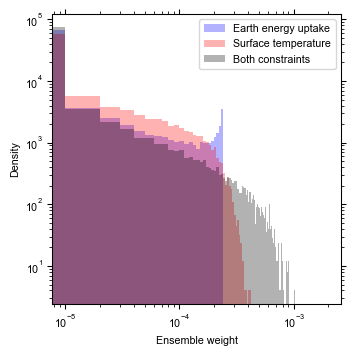

In [180]:
fig, ax = pl.subplots(figsize=(9.5/2.54, 9.5/2.54))
ax.hist(ks['ohc']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='blue', label='Earth energy uptake', density=True, histtype='stepfilled')
ax.hist(ks['temp']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='red', label='Surface temperature', density=True, histtype='stepfilled')
ax.hist(ks['multi']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='black', label='Both constraints', density=True, histtype='stepfilled')
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('Ensemble weight')
pl.yscale('log')
pl.xscale('log')
fig.tight_layout()
pl.savefig('../plots/constraint_density.png')
pl.savefig('../plots/constraint_density.pdf')
#pl.xlim(0,0.002)
#pl.ylim(0,1000)

In [181]:
# fig, ax = pl.subplots()
# colors_ssp = {
#     'CMIP6-SSP1-1.9': 'blue',
#     'CMIP6-SSP2-4.5': 'green',
#     'CMIP6-SSP3-7.0': 'red',
#     'CMIP6-ECLIPSE' : 'gray'
# }
# ax.plot(years, Tobs, color=colors['obs'])
# for expt in ['CMIP6-SSP1-1.9','CMIP6-SSP2-4.5', 'CMIP6-SSP3-7.0','CMIP6-ECLIPSE']:
#     ax.plot(np.arange(1750.5,2020), np.nansum((temp[expt] + intvar[:,:samples])*ks['multi'][expt], axis=1), color=colors_ssp[expt])
# ax.set_title('Best estimate aerosol forcing')
# ax.set_ylabel('Temperature change relative to 1850-1900, K')

(1960.0, 2019.0)

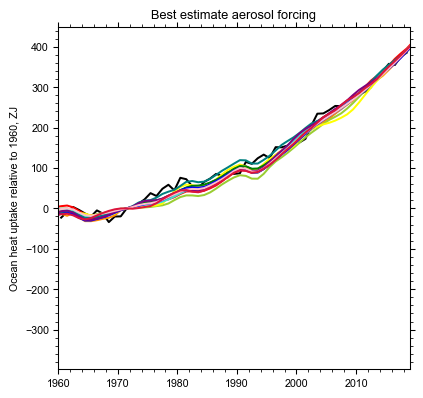

In [182]:
fig, ax = pl.subplots()
ax.plot(np.arange(1960.5,2019), (OHCobs-OHCobs[11])/1e21, color=colors['observations'])
for expt in expts:
    ax.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), color=colors[expt])
ax.set_title('Best estimate aerosol forcing')
ax.set_ylabel('Ocean heat uptake relative to 1960, ZJ')
ax.set_xlim(1960,2019)

In [183]:
# Throw TCR into the mix
tcr = np.loadtxt('../data/tcr.txt')

In [184]:
pc = {}
for expt in expts:
    pc[expt] = {}
    for constraint in ['temp', 'ohc', 'multi']:
        pc[expt][constraint] = {}
        pc[expt][constraint]['ECS'] = {}
        pc[expt][constraint]['TCR'] = {}
        for metric in ['GSAT','OHC','ERFari','ERFaci','ERFaer']:
            pc[expt][constraint][metric] = {}
            for perc in [5,16,50,84,95]:
                pc[expt][constraint][metric][perc] = np.zeros(270)
        (
            pc[expt][constraint]['ECS'][5],
            pc[expt][constraint]['ECS'][16],
            pc[expt][constraint]['ECS'][50],
            pc[expt][constraint]['ECS'][84],
            pc[expt][constraint]['ECS'][95]
        ) = (
            weighted_percentile(
                geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), ks[constraint][expt], [.05,.16,.5,.84,.95]
            )
        )
        (
            pc[expt][constraint]['TCR'][5],
            pc[expt][constraint]['TCR'][16],
            pc[expt][constraint]['TCR'][50],
            pc[expt][constraint]['TCR'][84],
            pc[expt][constraint]['TCR'][95]
        ) = weighted_percentile(tcr[:samples], ks[constraint][expt], [.05,.16,.5,.84,.95])
        for year in range(270):
            (
                pc[expt][constraint]['GSAT'][5][year],
                pc[expt][constraint]['GSAT'][16][year],
                pc[expt][constraint]['GSAT'][50][year],
                pc[expt][constraint]['GSAT'][84][year],
                pc[expt][constraint]['GSAT'][95][year] 
            ) = weighted_percentile(temp[expt][year,:] + intvar[year,:samples], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['OHC'][5][year],
                pc[expt][constraint]['OHC'][16][year],
                pc[expt][constraint]['OHC'][50][year],
                pc[expt][constraint]['OHC'][84][year],
                pc[expt][constraint]['OHC'][95][year] 
            ) = weighted_percentile(ohc[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFari'][5][year],
                pc[expt][constraint]['ERFari'][16][year],
                pc[expt][constraint]['ERFari'][50][year],
                pc[expt][constraint]['ERFari'][84][year],
                pc[expt][constraint]['ERFari'][95][year] 
            ) = weighted_percentile(ERFari[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFaci'][5][year],
                pc[expt][constraint]['ERFaci'][16][year],
                pc[expt][constraint]['ERFaci'][50][year],
                pc[expt][constraint]['ERFaci'][84][year],
                pc[expt][constraint]['ERFaci'][95][year] 
            ) = weighted_percentile(ERFaci[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFaer'][5][year],
                pc[expt][constraint]['ERFaer'][16][year],
                pc[expt][constraint]['ERFaer'][50][year],
                pc[expt][constraint]['ERFaer'][84][year],
                pc[expt][constraint]['ERFaer'][95][year] 
            ) = weighted_percentile(ERFari[expt][year,:]+ERFaci[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])

In [213]:
for constraint in ['temp','ohc','multi']:
    print(constraint)
    print('---------')
    for expt in expts:
        print(expt, constraint, 'ECS', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ECS'][5], pc[expt][constraint]['ECS'][16], pc[expt][constraint]['ECS'][50], pc[expt][constraint]['ECS'][84], pc[expt][constraint]['ECS'][95]))
        print(expt, constraint, 'TCR', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['TCR'][5], pc[expt][constraint]['TCR'][16], pc[expt][constraint]['TCR'][50], pc[expt][constraint]['TCR'][84], pc[expt][constraint]['TCR'][95]))
        print(expt, constraint, 'ERFaer', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFaer'][5][269], pc[expt][constraint]['ERFaer'][16][269], pc[expt][constraint]['ERFaer'][50][269], pc[expt][constraint]['ERFaer'][84][269], pc[expt][constraint]['ERFaer'][95][269]))
        print(expt, constraint, 'ERFari', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFari'][5][269], pc[expt][constraint]['ERFari'][16][269], pc[expt][constraint]['ERFari'][50][269], pc[expt][constraint]['ERFari'][84][269], pc[expt][constraint]['ERFari'][95][269]))
        print(expt, constraint, 'ERFaci', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFaci'][5][269], pc[expt][constraint]['ERFaci'][16][269], pc[expt][constraint]['ERFaci'][50][269], pc[expt][constraint]['ERFaci'][84][269], pc[expt][constraint]['ERFaci'][95][269]))
print('none')
print('---------')
for expt in expts:
    print(expt, constraint, 'ECS', np.percentile(geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), (5,16,50,84,95)))
    print(expt, constraint, 'TCR', np.percentile(tcr, (5,16,50,84,95)))
    print(expt, constraint, 'ERFaer', np.percentile(ERFari[expt][269,:]+ERFaci[expt][269,:], (5,16,50,84,95)))
    print(expt, constraint, 'ERFari', np.percentile(ERFari[expt][269,:], (5,16,50,84,95)))
    print(expt, constraint, 'ERFaci', np.percentile(ERFaci[expt][269,:], (5,16,50,84,95)))

temp
---------
CMIP6-constrained temp ECS 1.95 2.36 3.15 4.57 6.11
CMIP6-constrained temp TCR 1.37 1.54 1.85 2.29 2.66
CMIP6-constrained temp ERFaer -1.49 -1.22 -0.82 -0.48 -0.29
CMIP6-constrained temp ERFari -0.60 -0.44 -0.26 -0.13 -0.06
CMIP6-constrained temp ERFaci -1.15 -0.89 -0.53 -0.23 -0.08
ECLIPSE-constrained temp ECS 1.94 2.34 3.11 4.42 5.86
ECLIPSE-constrained temp TCR 1.37 1.53 1.82 2.24 2.57
ECLIPSE-constrained temp ERFaer -1.31 -1.00 -0.64 -0.35 -0.19
ECLIPSE-constrained temp ERFari -0.61 -0.41 -0.21 -0.09 -0.02
ECLIPSE-constrained temp ERFaci -0.93 -0.70 -0.40 -0.16 -0.03
CanESM5 temp ECS 1.91 2.31 3.00 4.25 5.52
CanESM5 temp TCR 1.34 1.51 1.79 2.17 2.46
CanESM5 temp ERFaer -0.81 -0.58 -0.25 0.01 0.15
CanESM5 temp ERFari 0.05 0.08 0.13 0.19 0.23
CanESM5 temp ERFaci -0.90 -0.68 -0.39 -0.15 -0.03
E3SM temp ECS 1.93 2.34 3.11 4.49 6.02
E3SM temp TCR 1.36 1.53 1.83 2.27 2.64
E3SM temp ERFaer -1.33 -1.16 -0.87 -0.58 -0.41
E3SM temp ERFari -0.66 -0.54 -0.37 -0.22 -0.14
E3SM tem

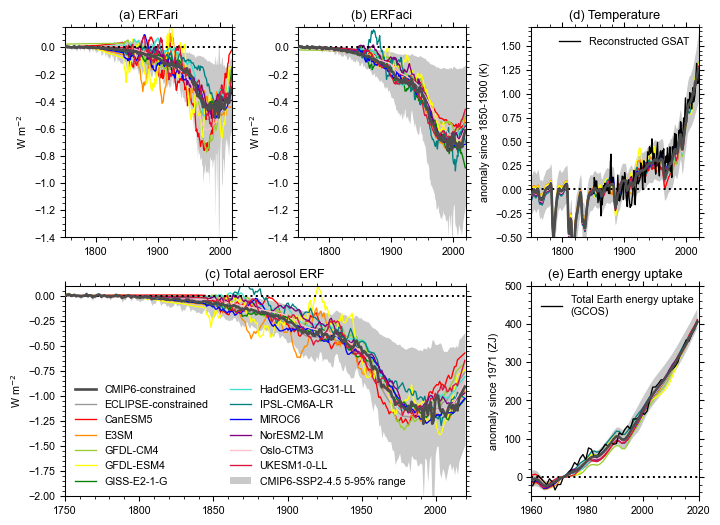

In [186]:
#fig, ax = pl.subplots(3,2,figsize=(16/2.54,23/2.54))
fig = pl.figure(figsize=(19/2.54,14/2.54))
gs = gridspec.GridSpec(ncols=6, nrows=2)
axtmp = fig.add_subplot(gs[0,4:6])
axohc = fig.add_subplot(gs[1,4:6])
axari = fig.add_subplot(gs[0,0:2])
axaci = fig.add_subplot(gs[0,2:4])
axaer = fig.add_subplot(gs[1,0:4])

expt='CMIP6-constrained'
axtmp.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['GSAT'][5], pc[expt]['multi']['GSAT'][95], color=colors[expt], alpha=0.3, lw=0)
axaer.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFaer'][5], pc[expt]['multi']['ERFaer'][95], color=colors[expt], alpha=0.3, lw=0, label='CMIP6-SSP2-4.5 5-95% range')
axari.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFari'][5], pc[expt]['multi']['ERFari'][95], color=colors[expt], alpha=0.3, lw=0)
axaci.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFaci'][5], pc[expt]['multi']['ERFaci'][95], color=colors[expt], alpha=0.3, lw=0)
axohc.fill_between(np.arange(1750.5,2020), 10*(pc[expt]['multi']['OHC'][5]-pc[expt]['multi']['OHC'][5][221]), 10*(pc[expt]['multi']['OHC'][95]-pc[expt]['multi']['OHC'][95][221]), color=colors[expt], alpha=0.3, lw=0)

for expt in expts:
    if expt=='CMIP6-constrained':
        lw=2
        zorder=10
        axtmp.plot(np.arange(1750.5,2020), np.nansum((temp[expt] + intvar[:,:samples])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)
        axaer.plot(np.arange(1750.5,2020), np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axari.plot(np.arange(1750.5,2020), np.nansum((ERFari[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axaci.plot(np.arange(1750.5,2020), np.nansum((ERFaci[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axohc.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)

    else:
        lw=1
        zorder=1
        axtmp.plot(np.arange(1750.5,2020), np.nansum((temp[expt] + intvar[:,:samples])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)
        axaer.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axari.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axaci.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axohc.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)


#axaer.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), label=expt, color=colors[expt])
axtmp.plot(years, Tobs, color=colors['observations'], label='Reconstructed GSAT', lw=1)
axohc.plot(np.arange(1960.5,2019), (OHCobs-OHCobs[11])/1e21, color=colors['observations'], lw=1, label='Total Earth energy uptake\n(GCOS)')
axtmp.legend(frameon=False)
axohc.legend(frameon=False, loc='upper left')
axtmp.set_xlim(1750,2020)
axtmp.set_ylim(-0.5,1.7)
axtmp.set_ylabel('anomaly since 1850-1900 (K)');
axtmp.set_title('(d) Temperature')
axtmp.axhline(0, ls=':', color='k')
axohc.axhline(0, ls=':', color='k')
axohc.set_ylabel('anomaly since 1971 (ZJ)')
axohc.set_title('(e) Earth energy uptake')
axohc.set_ylim(-50,500)
axohc.set_xlim(1960,2020)
axaer.set_xlim(1750,2020)
axaer.set_ylim(-2.0,0.1)
axaer.set_ylabel('W m$^{-2}$');
axaer.set_title('(c) Total aerosol ERF')
axaer.axhline(0, ls=':', color='k')
axaer.legend(fontsize=8, frameon=False, ncol=2);
axari.set_xlim(1750,2020)
axari.set_ylim(-1.4,0.15)
axari.set_ylabel('W m$^{-2}$');
axari.set_title('(a) ERFari')
axari.axhline(0, ls=':', color='k')
axaci.set_xlim(1750,2020)
axaci.set_ylim(-1.4,0.15)
axaci.set_ylabel('W m$^{-2}$');
axaci.set_title('(b) ERFaci')
axaci.axhline(0, ls=':', color='k')
fig.tight_layout()
pl.savefig('../plots/after_geoffroy_temp.png')
pl.savefig('../plots/after_geoffroy_temp.pdf')

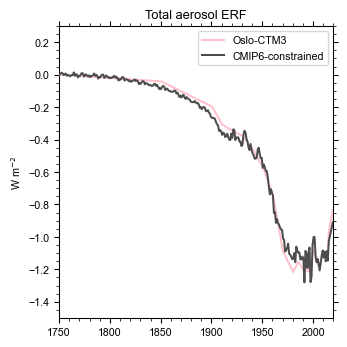

In [187]:
fig, ax = pl.subplots(figsize=(9.3/2.54,9.3/2.54))
#for expt in expts:
    #ax.fill_between(np.arange(1750.5,2020), savgol_filter(pc[expt]['multi']['ERFaer'][5], 11, 1), savgol_filter(pc[expt]['multi']['ERFaer'][95], 11, 1), color=colors[expt], alpha=0.3, lw=0)
#ax.fill_between(np.arange(1750.5,2020), pc['CMIP6-SSP2-4.5']['multi']['ERFaer'][5], pc['CMIP6-SSP2-4.5']['multi']['ERFaer'][95], color=colors['CMIP6-SSP2-4.5'], alpha=0.3, lw=0, label='CMIP6-SSP2-4.5 5-95% range')
#ax.fill_between(np.arange(1750.5,2020), pc['Lund']['multi']['ERFaer'][5], pc['Lund']['multi']['ERFaer'][95], color=colors['Lund'], alpha=0.3, lw=0, label='Lund et al., 5-95% range')
ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['Oslo-CTM3'][:270]+ERFaci['Oslo-CTM3'][:270])*ks['multi']['Oslo-CTM3'], axis=1), label='Oslo-CTM3', color=colors['Oslo-CTM3'], zorder=5)
ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-constrained'][:270]+ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1), label='CMIP6-constrained', color=colors['CMIP6-constrained'], zorder=5)

#ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-SSP1-1.9'][:270]+ERFaci['CMIP6-SSP1-1.9'][:270])*ks['multi']['CMIP6-SSP1-1.9'], axis=1), label='SSP1-1.9', color='green')
#ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-SSP2-4.5'][:270]+ERFaci['CMIP6-SSP2-4.5'][:270])*ks['multi']['CMIP6-SSP2-4.5'], axis=1), label='SSP2-4.5', color='blue')
#ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-SSP3-7.0'][:270]+ERFaci['CMIP6-SSP3-7.0'][:270])*ks['multi']['CMIP6-SSP3-7.0'], axis=1), label='SSP3-7.0', color='red')
#ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-ECLIPSE'][:270]+ERFaci['CMIP6-ECLIPSE'][:270])*ks['multi']['CMIP6-ECLIPSE'], axis=1), label='ECLIPSEv6b', color='gray')

ax.legend()#(fontsize=8);
ax.set_xlim(1750,2020)
ax.set_ylim(-1.5,0.3)
ax.set_title('Total aerosol ERF')
ax.set_ylabel('W m$^{-2}$')
fig.tight_layout()
pl.savefig('../plots/versus_lund.png')
pl.savefig('../plots/versus_lund.pdf')


In [188]:
year = np.arange(1750,2020)
erfaer = np.nansum((ERFari['CMIP6-constrained'][:270]+ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1)
erfaer05 = pc['CMIP6-constrained']['multi']['ERFaer'][5]
erfaer16 = pc['CMIP6-constrained']['multi']['ERFaer'][16]
erfaer50 = pc['CMIP6-constrained']['multi']['ERFaer'][50]
erfaer84 = pc['CMIP6-constrained']['multi']['ERFaer'][84]
erfaer95 = pc['CMIP6-constrained']['multi']['ERFaer'][95]
df = pd.DataFrame(data=np.array([year, erfaer05, erfaer16, erfaer, erfaer50, erfaer84, erfaer95]).T, columns =['year','pc05','pc16','mean','pc50','pc84','pc95'])
df = df.astype({'year':int})
df.set_index('year', inplace=True)
df.to_csv('../data/aerosol_forcing.csv')

In [189]:
erfaer[222:265].mean()

-1.1201541988213721

In [190]:
erfaer[255:265].mean()

-1.1336545748626694

In [209]:
print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][95][255:265]))
print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][50][255:265]))
print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][5][255:265]))

-0.4427275412808749
-0.9693152835381685
-1.5792472504461768


In [208]:
np.nansum(ERFaci['ECLIPSE-constrained'][269,:]*ks['multi']['ECLIPSE-constrained'])

-0.4809065566554831

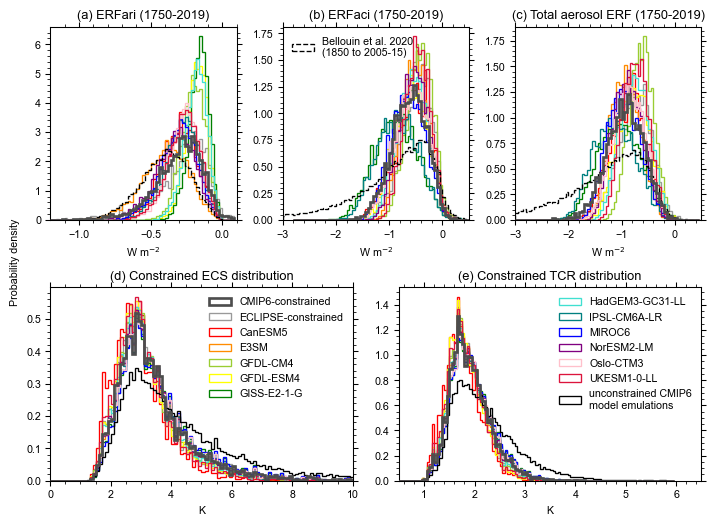

In [210]:
fig = pl.figure(figsize=(19/2.54,14/2.54))
gs = gridspec.GridSpec(ncols=6, nrows=2)
axecs = fig.add_subplot(gs[1,0:3])
axtcr = fig.add_subplot(gs[1,3:6])
axari = fig.add_subplot(gs[0,0:2])
axaci = fig.add_subplot(gs[0,2:4])
axaer = fig.add_subplot(gs[0,4:6])
histtype='step'
for i, expt in enumerate(expts):
    if expt=='CMIP6-constrained':
        zorder=10
        lw=2
    else:
        zorder=1
        lw=1
    if i<7:
        label1=expt
        label2=''
    else:
        label1=''
        label2=expt
    axari.hist(ERFari[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-1.2,0.1,0.02), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axaci.hist(ERFaci[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-2.8,0.85,0.05), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axaer.hist(ERFari[expt][268,:]+ERFaci[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-3,0.5,0.05), color=colors[expt], histtype='step', edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axecs.hist(geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), weights=ks['multi'][expt], bins=np.arange(0,10.1,0.1), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder, label=label1);
    axtcr.hist(tcr[:samples], weights=ks['multi'][expt][:samples], bins=np.arange(0,6,0.05), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, label=label2, zorder=zorder)
axari.hist(ERFari_scale, bins=np.arange(-1.2,0.1,0.02), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='Bellouin et al. 2020\n(1850 to 2005-15)');
axari.set_title('(a) ERFari (1750-2019)');
axari.set_xlabel('W m$^{-2}$')
axari.set_xlim(-1.2,0.1);
axaci.hist(ERFaci_scale, bins=np.arange(-3,0.85,0.05), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='Bellouin et al. 2020\n(1850 to 2005-15)');
axaci.set_title('(b) ERFaci (1750-2019)');
axaci.set_xlabel('W m$^{-2}$')
axaci.set_xlim(-3,0.5);
axaci.legend(loc='upper left', frameon=False);
axaer.hist(ERFari_scale+ERFaci_scale, bins=np.arange(-3,0.55,0.05), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='prior');
axaer.set_title('(c) Total aerosol ERF (1750-2019)');
axaer.set_xlabel('W m$^{-2}$')
axaer.set_xlim(-3,0.5);
axecs.hist(geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), bins=np.arange(0,10.1,0.1), color='k', histtype='step', edgecolor='k', lw=1, density=True);
axecs.set_title('(d) Constrained ECS distribution');
axecs.set_xlabel('K')
axecs.set_xlim(0,10)
axtcr.hist(tcr[:samples], bins=np.arange(0,6,0.05), color='k', histtype='step', edgecolor='k', lw=1, density=True, label='unconstrained CMIP6\nmodel emulations');
axtcr.set_title('(e) Constrained TCR distribution');
axtcr.set_xlabel('K')
axecs.legend(fontsize=8, frameon=False)
axtcr.legend(fontsize=8, frameon=False)
axtcr.set_xlim(0.5,6.5)
#ax.set_ylabel('Probability density')
pl.figtext(0.015,0.5,'Probability density', rotation=90, va='center', ha='center')

fig.tight_layout(rect=[0.015,0,1,1])
pl.savefig('../plots/distributions.png')
pl.savefig('../plots/distributions.pdf');

In [194]:
slopes = np.zeros(samples)
for i in range(samples):
    sl, _,_,_,_ = st.linregress(np.arange(35), ERFari['CMIP6-constrained'][230:265,i]+ERFaci['CMIP6-constrained'][230:265,i])
    slopes[i] = sl

In [195]:
sl_cmip = {}
sl_cmip['CanESM5'],_,_,_,_ = st.linregress(np.arange(35), CanESM5_aerforcing.loc[130:164,'erf'])
sl_cmip['E3SM'],_,_,_,_ = st.linregress(np.arange(35), E3SM_aerforcing.loc[110:144,'erf'])
sl_cmip['GFDL-CM4'],_,_,_,_ = st.linregress(np.arange(35), GFDL_aerforcing.loc[130:164,'erf'])
sl_cmip['GFDL-ESM4'],_,_,_,_ = st.linregress(np.arange(35), GFDLESM_aerforcing.loc[130:164,'erf'])
sl_cmip['GISS-E2-1-G'],_,_,_,_ = st.linregress(np.arange(35), GISS_aerforcing.loc[130:164,'erf'])
sl_cmip['HadGEM3-GC31-LL'],_,_,_,_ = st.linregress(np.arange(35), HadGEM3_aerforcing.loc[130:164,'erf'])
sl_cmip['IPSL-CM6A-LR'],_,_,_,_ = st.linregress(np.arange(35), IPSL_aerforcing.loc[130:164,'erf'])
sl_cmip['MIROC6'],_,_,_,_ = st.linregress(np.arange(35), MIROC6_aerforcing.loc[130:164,'erf'])
sl_cmip['NorESM2-LM'],_,_,_,_ = st.linregress(np.arange(35), NorESM2_aerforcing.loc[130:164,'erf'])
sl_cmip['UKESM1-0-LL'],_,_,_,_ = st.linregress(np.arange(35), UKESM_aerforcing.loc[130:164,'erf'])
sl_cmip

{'CanESM5': 0.006517598646765829,
 'E3SM': 0.006892768855495043,
 'GFDL-CM4': 0.007782870814745554,
 'GFDL-ESM4': 0.003704431162657955,
 'GISS-E2-1-G': -0.0026189997649882176,
 'HadGEM3-GC31-LL': 0.006568982913596437,
 'IPSL-CM6A-LR': -0.002968048960013907,
 'MIROC6': -0.0011194016074014572,
 'NorESM2-LM': 0.0075198140232175725,
 'UKESM1-0-LL': 0.015152011105059702}

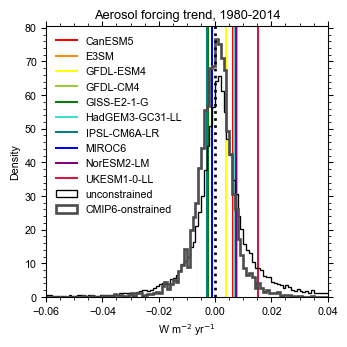

In [199]:
pl.figure(figsize=(9.3/2.54,9.3/2.54))
pl.hist(slopes, bins=np.arange(-0.06,0.05,0.001), density=True, color='k', label='unconstrained', histtype='step');
pl.hist(slopes, weights=ks['multi']['CMIP6-constrained'], bins=np.arange(-0.06,0.05,0.001), density=True, histtype='step', color=colors['CMIP6-constrained'], lw=2, label='CMIP6-onstrained');
for model in models:
    pl.axvline(sl_cmip[model], color=colors[model], zorder=-1, label=model)
pl.title('Aerosol forcing trend, 1980-2014')
pl.xlabel('W m$^{-2}$ yr$^{-1}$')
pl.ylabel('Density')
pl.axvline(0, ls=':', color='k', lw=2)
pl.legend(frameon=False);
pl.xlim(-0.06,0.04)
pl.tight_layout();
pl.savefig('../plots/trend.png');
pl.savefig('../plots/trend.pdf');

## Plot comparisons for Bill

1) It would be good to see the multi-model mean raw ERF, the emulated ERF, and the satellites  on the same plot so we could compare them. Presumably if the emulated ERFs have a weaker trend 1950-2014, they must have a stronger trend 1850-1950? This would imply either that the CEDS emissions don’t increase early enough, or the models are not non-linear enough.

In [ ]:
expt='CMIP6-constrained'
pl.fill_between(np.arange(1750,2020), pc[expt]['multi']['ERFaer'][5], pc[expt]['multi']['ERFaer'][95], color=colors[expt], alpha=0.3, lw=0, label='Energy budget constraint 5-95% range')

pl.plot(np.arange(1850,2026), CanESM5_aerforcing.loc[:175,'erf'], color=colors['CanESM5'], alpha=0.8, label='CanESM5')
pl.plot(np.arange(1870,2015), E3SM_aerforcing.loc[:,'erf'], color=colors['E3SM'], alpha=0.8, label='E3SM')
pl.plot(np.arange(1850,2026), GFDL_aerforcing.loc[:175,'erf'], color=colors['GFDL-CM4'], alpha=0.8, label='GFDL-CM4')
pl.plot(np.arange(1850,2026), GISS_aerforcing.loc[:175,'erf'], color=colors['GISS-E2-1-G'], alpha=0.8, label='GISS-E2-1-G')
pl.plot(np.arange(1850,2026), HadGEM3_aerforcing.loc[:175,'erf'], color=colors['HadGEM3-GC31-LL'], alpha=0.8, label='HadGEM3-GC31-LL')
pl.plot(np.arange(1850,2026), MIROC6_aerforcing.loc[:175,'erf'], color=colors['MIROC6'], alpha=0.8, label='MIROC6')
pl.plot(np.arange(1850,2015), NorESM2_aerforcing.loc[:,'erf'], color=colors['NorESM2-LM'], alpha=0.8, label='NorESM2-LM')
pl.plot(np.arange(1980,2020), MERRA2_ari+MERRA2_aci, color='k', lw=3, label='MERRA2 RFari+ERaci')
pl.plot(np.arange(1850,2020), np.nansum((ERFari['CMIP6-constrained'][100:270]+ERFaci['CMIP6-constrained'][100:270])*ks['multi']['CMIP6-constrained'], axis=1), lw=3, color=colors['CMIP6-constrained'], label='Energy budget constraint')
pl.ylim(-2.2,0.5)
pl.xlim(1850,2025)
pl.legend(ncol=1, frameon=False)
pl.title('Models v emulator v observations')
pl.savefig('../plots/CMIP6_emulator_obs.png')

In [200]:
models = ['CanESM5','E3SM','GFDL-ESM4','GFDL-CM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','NorESM2-LM','UKESM1-0-LL']
df = pd.read_csv('../data/erf_aer_emulations.csv')
forcing = {}
for model in models:
    forcing[model] = {}
    forcing[model]['aer'] = np.ones(275)*np.nan
    forcing[model]['aer'][:120] = df[model].values[:120]-df[model].values[0]
forcing['CanESM5']['aer'][100:] = CanESM5_aerforcing.loc[:174,'erf']-df['CanESM5'][0]
forcing['E3SM']['aer'][120:265] = E3SM_aerforcing.loc[:,'erf']-df['E3SM'][0]
forcing['GFDL-ESM4']['aer'][100:265] = GFDLESM_aerforcing.loc[:,'erf']-df['GFDL-ESM4'][0]
forcing['GFDL-CM4']['aer'][100:] = GFDL_aerforcing.loc[:174,'erf']-df['GFDL-CM4'][0]
forcing['GISS-E2-1-G']['aer'][100:] = GISS_aerforcing.loc[:174,'erf']-df['GISS-E2-1-G'][0]
forcing['HadGEM3-GC31-LL']['aer'][100:] = HadGEM3_aerforcing.loc[:174,'erf']-df['HadGEM3-GC31-LL'][0]
forcing['IPSL-CM6A-LR']['aer'][100:] = IPSL_aerforcing.loc[:174,'erf']-df['IPSL-CM6A-LR'][0]
forcing['MIROC6']['aer'][100:] = MIROC6_aerforcing.loc[:174,'erf']-df['MIROC6'][0]
forcing['NorESM2-LM']['aer'][100:265] = NorESM2_aerforcing.loc[:,'erf']-df['NorESM2-LM'][0]
forcing['UKESM1-0-LL']['aer'][100:265] = UKESM_aerforcing.loc[:,'erf']-df['UKESM1-0-LL'][0]

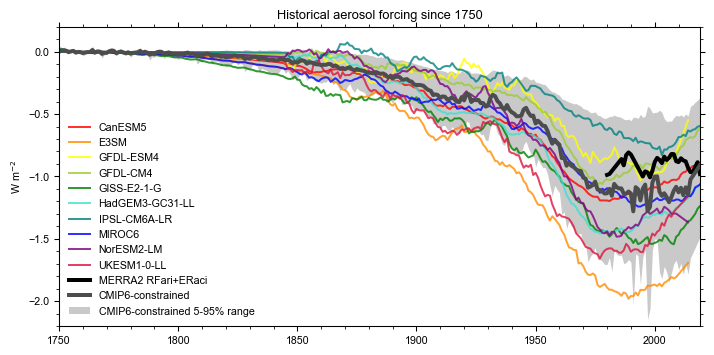

In [201]:
fig, ax = pl.subplots(figsize=(19/2.54, 9.5/2.54))
expt='CMIP6-constrained'
ax.fill_between(np.arange(1750,2020), pc[expt]['multi']['ERFaer'][5], pc[expt]['multi']['ERFaer'][95], color=colors[expt], alpha=0.3, lw=0, label='CMIP6-constrained 5-95% range')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['CanESM5']['aer'], 11, 1), color=colors['CanESM5'], alpha=0.8, label='CanESM5')
ax.plot(np.arange(1750,2015), savgol_filter(forcing['E3SM']['aer'][:265], 11, 1), color=colors['E3SM'], alpha=0.8, label='E3SM')
ax.plot(np.arange(1750,2015), savgol_filter(forcing['GFDL-ESM4']['aer'][:265], 11, 1), color=colors['GFDL-ESM4'], alpha=0.8, label='GFDL-ESM4')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['GFDL-CM4']['aer'], 11, 1), color=colors['GFDL-CM4'], alpha=0.8, label='GFDL-CM4')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['GISS-E2-1-G']['aer'], 11, 1), color=colors['GISS-E2-1-G'], alpha=0.8, label='GISS-E2-1-G')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['HadGEM3-GC31-LL']['aer'], 11, 1), color=colors['HadGEM3-GC31-LL'], alpha=0.8, label='HadGEM3-GC31-LL')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['IPSL-CM6A-LR']['aer'], 11, 1), color=colors['IPSL-CM6A-LR'], alpha=0.8, label='IPSL-CM6A-LR')
ax.plot(np.arange(1750,2025), savgol_filter(forcing['MIROC6']['aer'], 11, 1), color=colors['MIROC6'], alpha=0.8, label='MIROC6')
ax.plot(np.arange(1750,2015), savgol_filter(forcing['NorESM2-LM']['aer'][:265], 11, 1), color=colors['NorESM2-LM'], alpha=0.8, label='NorESM2-LM')
ax.plot(np.arange(1750,2015), savgol_filter(forcing['UKESM1-0-LL']['aer'][:265], 11, 1), color=colors['UKESM1-0-LL'], alpha=0.8, label='UKESM1-0-LL')
ax.plot(np.arange(1980,2020), MERRA2_ari+MERRA2_aci, color='k', lw=3, label='MERRA2 RFari+ERaci')
ax.plot(np.arange(1750,2020), np.nansum((ERFari['CMIP6-constrained'][:270]+ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1), lw=3, color=colors['CMIP6-constrained'], label='CMIP6-constrained')
ax.set_ylim(-2.2,0.2)
ax.set_xlim(1750,2019)
ax.legend(ncol=1, frameon=False)
ax.set_title('Historical aerosol forcing since 1750')
ax.set_ylabel('W m$^{-2}$')
fig.tight_layout()
pl.savefig('../plots/CMIP6smoothed_emulator_obs.png')
pl.savefig('../plots/CMIP6smoothed_emulator_obs.pdf')

In [ ]:
expt='CMIP6-SSP2-4.5'
pl.fill_between(np.arange(1750,2020), pc[expt]['multi']['ERFaer'][5], pc[expt]['multi']['ERFaer'][95], color=colors[expt], alpha=0.3, lw=0, label='Energy budget constraint 5-95% range')


mod7 = np.ones((175,7))*np.nan
mod7[:,0] = CanESM5_aerforcing.loc[:174,'erf']
mod7[20:165,1] = E3SM_aerforcing.loc[:,'erf']
mod7[:,2] = GFDL_aerforcing.loc[:174,'erf']
mod7[:,3] = GISS_aerforcing.loc[:174,'erf']
mod7[:,4] = HadGEM3_aerforcing.loc[:174,'erf']
mod7[:,5] = MIROC6_aerforcing.loc[:174,'erf']
mod7[:165,6] = NorESM2_aerforcing.loc[:,'erf']
mmm = np.nanmean(mod7, axis=1)

pl.plot(np.arange(1850,2025), mmm, color='k', alpha=0.8, label='CMIP6 multi-model mean')
pl.plot(np.arange(1980,2020), MERRA2_ari+MERRA2_aci, color='k', lw=3, label='MERRA2 RFari+ERaci')
pl.plot(np.arange(1850,2020), np.nansum((ERFari['CMIP6-SSP2-4.5'][100:270]+ERFaci['CMIP6-SSP2-4.5'][100:270])*ks['multi']['CMIP6-SSP2-4.5'], axis=1), lw=3, color=colors['CMIP6-SSP2-4.5'], label='Energy budget constraint')
pl.ylim(-2.2,0.5)
pl.xlim(1850,2025)
pl.legend(ncol=1, frameon=False)
pl.title('Models v emulator v observations')
pl.savefig('../plots/CMIP6mmm_emulator_obs.png')

In [ ]:
pl.fill_between(np.arange(1750,2020), -1.2/-1.07*pc[expt]['multi']['ERFaer'][5], -1.2/-1.07*pc[expt]['multi']['ERFaer'][95], color=colors[expt], alpha=0.3, lw=0, label='Energy budget constraint 5-95% range')
pl.plot(np.arange(1850,2026), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='CanESM5'].ERF.values[0] * savgol_filter(CanESM5_aerforcing.loc[:175,'erf'], 11, 1), color=colors['CanESM5'], alpha=0.8, label='CanESM5')
pl.plot(np.arange(1870,2015), -1.2/(-1.65) * savgol_filter(E3SM_aerforcing.loc[:,'erf'], 11, 1), color=colors['E3SM'], alpha=0.8, label='E3SM')
pl.plot(np.arange(1850,2026), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='GFDL-CM4'].ERF.values[0] * savgol_filter(GFDL_aerforcing.loc[:175,'erf'], 11, 1), color=colors['GFDL-CM4'], alpha=0.8, label='GFDL-CM4')
pl.plot(np.arange(1850,2026), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='GISS-E2-1-G'].ERF.values[0] * savgol_filter(GISS_aerforcing.loc[:175,'erf'], 11, 1), color=colors['GISS-E2-1-G'], alpha=0.8, label='GISS-E2-1-G')
pl.plot(np.arange(1850,2026), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='HadGEM3-GC31-LL'].ERF.values[0] * savgol_filter(HadGEM3_aerforcing.loc[:175,'erf'], 11, 1), color=colors['HadGEM3-GC31-LL'], alpha=0.8, label='HadGEM3-GC31-LL')
pl.plot(np.arange(1850,2026), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='MIROC6'].ERF.values[0] * savgol_filter(MIROC6_aerforcing.loc[:175,'erf'], 11, 1), color=colors['MIROC6'], alpha=0.8, label='MIROC6')
pl.plot(np.arange(1850,2015), -1.2/RFMIP_aerforcing[RFMIP_aerforcing['Model']=='NorESM2-LM'].ERF.values[0] * savgol_filter(NorESM2_aerforcing.loc[:,'erf'], 11, 1), color=colors['NorESM2-LM'], alpha=0.8, label='NorESM2-LM')
pl.plot(np.arange(1980,2020), -1.2/(MERRA2_ari+MERRA2_aci)[34]*(MERRA2_ari+MERRA2_aci), color='k', lw=3, label='MERRA2 RFari+ERaci', alpha=0.8)
pl.plot(np.arange(1850,2020), -1.2/-1.07*np.nansum((ERFari['CMIP6-SSP2-4.5'][100:270]+ERFaci['CMIP6-SSP2-4.5'][100:270])*ks['multi']['CMIP6-SSP2-4.5'], axis=1), lw=3, color=colors['CMIP6-SSP2-4.5'], alpha=0.8, label='Energy budget constraint')
pl.ylim(-2.2,0.5)
pl.xlim(1850,2025)
pl.legend(ncol=1, frameon=False)
pl.title('Models (smoothed) v emulator v observations')
pl.text(1870,0.25,'Scaled so that all timeseries = -1.2 W m$^{-2}$ in 2014', fontsize=10)
pl.savefig('../plots/CMIP6smoothed_emulator_obs_allscaled2014minus1.2.png')